# Question generation tests
Let's test how well we can generate questions for the "clean" CNN data with crowdsourced questions and the noisy NYT data with user-generated questions.

In [1]:
## load data
import pandas as pd
import os
import re
cnn_article_dir = '../../data/CNN_articles/cnn/stories/'
cnn_article_files = list(map(lambda x: os.path.join(cnn_article_dir, x), os.listdir(cnn_article_dir)))
cnn_article_data = pd.DataFrame(list(map(lambda x: ' '.join(list(map(lambda x: x.strip(), open(x, 'r').readlines()))), cnn_article_files)),
                                columns=['article_text'])
article_id_matcher = re.compile('[a-z0-9]+(?=\.story)')
cnn_article_ids = list(map(lambda x: article_id_matcher.search(x).group(0), cnn_article_files))
cnn_article_data = cnn_article_data.assign(**{
    'article_id' : cnn_article_ids
})
display(cnn_article_data.head())

,article_text,article_id
0,(CNN) -- It's been a busy few days in the worl...,23f7ab281ef416e1cdcd9c6fc359278a40a6ba34
1,Ten loveable mutts rescued from the streets of...,a8ac73078f8774a5addac799a22d0634278e79d1
2,Ken Henggeler poured his grief into the thing ...,022713fd20ac0ffd0ddccec6d9389beedd681893
3,Tokyo (CNN) -- Japan's prime minister vowed to...,d62d6364625d1522c55024486ec25851687935e3
4,(CNN) -- The leadership of North Korea appeare...,911597eecfe5d00d39de94f17c2a8400fcb4b994


In [2]:
cnn_question_file = '../../data/CNN_articles/cnn/newsqa-data-v1/newsqa-data-v1.csv'
full_cnn_question_data = pd.read_csv(cnn_question_file, sep=',', index_col=False, usecols=['story_id', 'question', 'is_answer_absent', 'is_question_bad', 'answer_char_ranges'])
full_cnn_question_data.rename(columns={'story_id' : 'article_id'}, inplace=True)
# get article IDs
cnn_article_id_matcher = re.compile('[0-9a-zA-Z]+(?=\.story)')
full_cnn_question_data = full_cnn_question_data.assign(**{
    'article_id' : full_cnn_question_data.loc[:, 'article_id'].apply(lambda x: cnn_article_id_matcher.search(x).group(0))
})
# clean answers
full_cnn_question_data = full_cnn_question_data.assign(**{
    'answer_char_ranges' : full_cnn_question_data.loc[:, 'answer_char_ranges'].apply(lambda x: list(filter(lambda x: x!='None', x.split('|')))),
})

def extract_char_range(txt):
    txt_splits = txt.split(',')
    char_range = list(map(lambda x: list(map(lambda y: int(y), x.split(':'))), txt_splits))
    return char_range
def extract_all_char_ranges(txt):
    char_ranges = list(map(lambda y: extract_char_range(y), txt))
    # flatten lol
    flat_char_ranges = []
    for char_range_i in char_ranges:
        flat_char_ranges += char_range_i
    return flat_char_ranges
full_cnn_question_data = full_cnn_question_data.assign(**{
    'clean_answer_char_ranges' : full_cnn_question_data.loc[:, 'answer_char_ranges'].apply(lambda x: extract_all_char_ranges(x)),
})
# get rid of unclear questions
# NOTE: we may need the different "bad" ratings later when testing word overlap
full_cnn_question_data = full_cnn_question_data[full_cnn_question_data.loc[:, 'is_question_bad']!='?']
full_cnn_question_data = full_cnn_question_data.assign(**{'is_question_bad' : full_cnn_question_data.loc[:, 'is_question_bad'].astype(float)})
# remove bad questions
cnn_question_data = full_cnn_question_data[(full_cnn_question_data.loc[:, 'is_answer_absent']==0.) &
                                           (full_cnn_question_data.loc[:, 'is_question_bad']==0.)]
display(cnn_question_data.head())


,article_id,question,answer_char_ranges,is_answer_absent,is_question_bad,clean_answer_char_ranges
0,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was the amount of children murdered?,[294:297],0.0,0.0,"[[294, 297]]"
1,c48228a52f26aca65c31fad273e66164f047f292,Where was one employee killed?,"[34:60, 1610:1618, 34:60]",0.0,0.0,"[[34, 60], [1610, 1618], [34, 60]]"
2,c65ed85800e4535f4bbbfa2c34d7d9630358d303,who did say South Africa did not issue a visa ...,"[103:127, 114:127, 839:853]",0.0,0.0,"[[103, 127], [114, 127], [839, 853]]"
3,0cf66b646e9b32076513c050edf32a799200c3c2,How many years old was the businessman?,"[538:550, 538:550]",0.0,0.0,"[[538, 550], [538, 550]]"
4,13012604e3203c18df09289dfedd14cde67cf40b,What frightened the families?,"[690:742, 688:791, 630:646]",0.0,0.0,"[[690, 742], [688, 791], [630, 646]]"


In [3]:
## combine article/comment
cnn_article_question_data = pd.merge(cnn_question_data, cnn_article_data, on='article_id')
cnn_article_question_data = cnn_article_question_data[~cnn_article_question_data.loc[:, 'article_text'].apply(lambda x: type(x) is float and np.isnan(x))]
## get answers to validate questions
cnn_article_question_data = cnn_article_question_data.assign(**{
    
})
cnn_article_question_data = cnn_article_question_data.assign(**{
    'clean_answers' : cnn_article_question_data.apply(lambda x: list(map(lambda y: x.loc['article_text'][y[0]:y[1]], x.loc['clean_answer_char_ranges'])), axis=1)
})

In [4]:
print(f'{cnn_article_question_data.shape[0]} questions')

63672 questions


In [5]:
display(cnn_article_question_data.head(5))

,article_id,question,answer_char_ranges,is_answer_absent,is_question_bad,clean_answer_char_ranges,article_text,clean_answers
0,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was the amount of children murdered?,[294:297],0.0,0.0,"[[294, 297]]","NEW DELHI, India (CNN) -- A high court in nort...",[ict]
1,42d01e187213e86f5fe617fe32e716ff7fa3afc4,When was Pandher sentenced to death?,"[261:271, 258:271, 261:271]",0.0,0.0,"[[261, 271], [258, 271], [261, 271]]","NEW DELHI, India (CNN) -- A high court in nort...","[bruary. T, February. T, bruary. T]"
2,42d01e187213e86f5fe617fe32e716ff7fa3afc4,The court aquitted Moninder Singh Pandher of w...,"[26:33, 624:640]",0.0,0.0,"[[26, 33], [624, 640]]","NEW DELHI, India (CNN) -- A high court in nort...","[A high , murder of the 1]"
3,42d01e187213e86f5fe617fe32e716ff7fa3afc4,who was acquitted,"[195:218, 195:218]",0.0,0.0,"[[195, 218], [195, 218]]","NEW DELHI, India (CNN) -- A high court in nort...","[ninder Singh Pandher wa, ninder Singh Pandher..."
4,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was Moninder Singh Pandher acquitted for?,"[129:192, 129:151, 133:151]",0.0,0.0,"[[129, 192], [129, 151], [133, 151]]","NEW DELHI, India (CNN) -- A high court in nort...","[the killing of a teen in a case dubbed ""the h..."


### Train model
Let's try an actual trained QA model with all the bells/whistles first, downloaded from [here](https://github.com/patil-suraj/question_generation.git).

In [6]:
import sys
if('question_generation/' not in sys.path):
    sys.path.append('question_generation/')
## NOTE need to run pipeline once to download (expensive!!) models
from pipelines import pipeline
# print(help(pipeline))
question_pipeline = pipeline('question-generation')

In [7]:
## test short text
text = "Python is an interpreted, high-level, general-purpose programming language. Created by Guido van Rossum \
and first released in 1991, Python's design philosophy emphasizes code \
readability with its notable use of significant whitespace."
text_question = question_pipeline(text)
print(text_question)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/transformers/tokenization_t5.py:183: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


[{'answer': 'Python', 'question': 'What is an interpreted, high-level, general-purpose programming language?'}, {'answer': 'Guido van Rossum', 'question': 'Who created Python?'}]


In [8]:
# test with article, which can be longer
test_cnn_article_question_data = cnn_article_question_data.iloc[0, :]
test_article = test_cnn_article_question_data.loc['article_text']
test_gold_question = test_cnn_article_question_data.loc['question']
print(f'{test_article[:300]}...')
test_article_questions = question_pipeline(test_article)
print(f'generated questions = {test_article_questions}')
print(f'gold question = {test_gold_question}')

NEW DELHI, India (CNN) -- A high court in northern India on Friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed "the house of horrors."  Moninder Singh Pandher was sentenced to death by a lower court in February.  The teen was one of 19 victims...
generated questions = [{'answer': 'the house of horrors', 'question': 'What was the name of the case that was acquitted by a high court in northern India?'}, {'answer': 'February', 'question': 'When was Moninder Singh Pandher sentenced to death?'}, {'answer': '19', 'question': 'How many victims did Moninder Singh Pandher have?'}, {'answer': 'Sikandar B. Kochar', 'question': "Who was Moninder Singh Pandher's lawyer?"}, {'answer': 'Surinder Koli', 'question': "Who was Pandher's domestic employee?"}, {'answer': 'Koli', 'question': "Who's death sentence was upheld by the high court?"}, {'answer': 'Noida', 'question': "Where was Pandher's home found?"}, {'answer': 'house of horrors', 'questio

Even though the wording is different, we see that the gold question is captured in at least one of the generated questions (`How many victims...`).

### Generate, evalute questions for articles

Let's try generating questions for all the articles and see how potentially useful they would be. They may be restricted to within-sentence reasoning and therefore not too complicated.

In [51]:
from tqdm import tqdm
tqdm.pandas()
def generate_questions(text, question_model):
    questions = []
    try:
        questions = question_model(text)
    except Exception as e:
        print(f'no questions because error {e}')
    return questions
article_var = 'article_text'
cnn_article_data_with_questions = cnn_article_data[cnn_article_data.loc[:, 'article_id'].isin(cnn_article_question_data.loc[:, 'article_id'].values)]
import numpy as np
np.random.seed(123)
# sample_size = 500
sample_size = cnn_article_data_with_questions.shape[0]
sample_cnn_article_data_with_questions = cnn_article_data_with_questions.loc[np.random.choice(cnn_article_data_with_questions.index, sample_size, replace=False), :]
sample_cnn_article_generated_questions = sample_cnn_article_data_with_questions.loc[:, article_var].progress_apply(lambda x: generate_questions(x, question_pipeline))

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 12/11852 [00:16<5:03:36,  1.54s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/transformers/tokenization_t5.py:183: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
 26%|██▌       | 3106/11852 [1:11:28<3:47:07,  1.56s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
# ## combine with other data 
# sample_cnn_article_generated_question_data = sample_cnn_article_generated_questions.reset_index(name='article_questions').drop('index', axis=1).assign(**{'article_id' : sample_cnn_article_data_with_questions.loc[:, 'article_id'].values})
# # display(sample_cnn_article_generated_question_data.head())
# sample_cnn_article_generated_question_data = pd.merge(sample_cnn_article_generated_question_data, cnn_article_question_data, on='article_id', how='left')
display(sample_cnn_article_generated_question_data.head())
## save to file
out_file = '../../data/CNN_articles/cnn/article_generated_question_data.tsv'
sample_cnn_article_generated_question_data.to_csv(out_file, sep='\t', index=False)

,article_questions,article_id,question,answer_char_ranges,is_answer_absent,is_question_bad,clean_answer_char_ranges,article_text,clean_answers,best_question_score,best_question
49617,"[{'answer': 'Stephen Hawking', 'question': 'Wh...",511fa443bdaabb7845aba2cb69737c96d7efd757,who is the world's greatest living scientist?,"[72:88, 72:88]",0.0,0.0,"[[72, 88], [72, 88]]","LONDON, England (CNN) -- Cosmologist, theoreti...","[Stephen Hawking , Stephen Hawking ]",1.0,who is the world's greatest living scientist?
17185,"[{'answer': '2-0', 'question': 'When did Inter...",b0a5fb32fb2d97a4ff49362a77aa7288914b44b6,who beat lazio 2-0?,"[10:22, 10:22]",0.0,0.0,"[[10, 22], [10, 22]]",(CNN) -- Inter Milan stayed on course for the...,"[Inter Milan , Inter Milan ]",1.0,who beat lazio 2-0?
17039,"[{'answer': 'Christmas Eve', 'question': 'When...",4872125bdb96f745b14fea0f09c3f3773e2fe551,who argued over gambling debt?,"[20:62, 288:326, 20:62]",0.0,0.0,"[[20, 62], [288, 326], [20, 62]]",Washington (CNN) -- Two Washington Wizards bas...,"[Two Washington Wizards basketball players , e...",1.0,who argued over gambling debt?
56153,"[{'answer': 'John Albert Gardner III', 'questi...",85a7aaa5b67a30872d4f47f0ec930465bfb442e8,what did gardner plead guilty to?,"[1609:1655,1743:1763,1766:1778, 368:378, 1743:...",0.0,0.0,"[[1609, 1655], [1743, 1763], [1766, 1778], [36...",(CNN) -- Admitted killer John Albert Gardner I...,[go-area teens in a deal with prosecutors that...,1.0,what did gardner plead guilty to?
47413,"[{'answer': 'Department of Veterans Affairs', ...",ff0e56f0be51bc47d57b7e162711eef48e43a1b3,how many veterans are homeless?,"[831:839, 831:839]",0.0,0.0,"[[831, 839], [831, 839]]","Washington (CNN) -- With a simple, declarative...","[veterans, veterans]",1.0,how many veterans are homeless?


How much do these questions overlap with the "gold" questions?

Let's test for maximum overlap: we assume that higher overlap among questions means more likelihood that the questions are identical.

In [55]:
from nltk.translate.bleu_score import sentence_bleu
def compute_text_bleu(txt_1, txt_2, weights):
    score = sentence_bleu([txt_1], txt_2, weights=weights)
    return score
def compute_max_sent_score(test_questions, gold_question, weights):
    test_question_text = list(map(lambda x: x['question'].lower(), test_questions))
    test_question_bleu_scores = np.array(list(map(lambda x: compute_text_bleu(x, gold_question, weights=weights), test_question_text)))
    max_score = np.max(test_question_bleu_scores)
    max_score_question = test_question_text[np.where(test_question_bleu_scores == max_score)[0][0]]
    return max_score, max_score_question
# BLEU-1
bleu_weights = [1.0, 0., 0., 0.]
## first test: do the "best" matches actually make sense?
for idx_i, data_i in sample_cnn_article_generated_question_data.drop_duplicates('article_id').iloc[:10, :].iterrows():
    print(f'gold question = {data_i.loc["question"]}')
    print(f'generated questions = {data_i.loc["article_questions"]}')
    best_question_score_i, best_question_i = compute_max_sent_score(data_i.loc['article_questions'], 
                                                                    data_i.loc['question'], 
                                                                    weights=bleu_weights)
    print(f'best question = <{best_question_i}> (score={best_question_score_i})')
    # print(compute_text_bleu(sample_cnn_article_generated_question_data.iloc[0, :].loc['article_questions'][0]['question'], 
    #                         sample_cnn_article_generated_question_data.iloc[0, :].loc['question'], 
    #                         weights=bleu_weights))

gold question = when these soldiers return
generated questions = [{'answer': '4,000', 'question': 'How many troops will the United States withdraw in Iraq by the end of October?'}, {'answer': 'next year', 'question': 'What year is the U.S. on track to end its combat mission in Iraq?'}, {'answer': 'Ray Odierno', 'question': 'Who is expected to tell the House of Representatives Armed Services Committee that there has been a significant drop in violence in Iraq recently?'}, {'answer': 'August 31, 2010', 'question': 'When will the U.S. combat mission in Iraq end?'}, {'answer': '35,000 to 50,000', 'question': 'How many support troops did Obama plan to keep on the ground in Iraq?'}, {'answer': '124,000', 'question': 'How many troops are there in Iraq today?'}, {'answer': '120,000', 'question': 'How many troops are in Iraq by the end of October?'}, {'answer': 'statistics', 'question': "What is Odierno's view of Iraq's violence?"}, {'answer': '85 percent', 'question': 'What percentage of Iraqi

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

The "best score" questions do get some words correct (`tried` vs. `trial`) but they are still missing the mark (low precision) and the generated questions often don't contain the gold question anyway (low recall). Some of the questions require multiple hops of reasoning and some questions are also more broad than the model is expecting (`what happened to jim carroll`). We may need more complicated models!

Let's look at the questions with the highest scores and determine if there is a cutoff that we can use for identifying actual matches.

In [64]:
# bleu_weights = [1.0, 0., 0., 0.]
# sample_cnn_article_generated_question_data = sample_cnn_article_generated_question_data.assign(**{
#     'best_question_score' : sample_cnn_article_generated_question_data.apply(lambda x: compute_max_sent_score(x.loc['article_questions'], x.loc['question'], weights=bleu_weights), axis=1)
# })
# sample_cnn_article_generated_question_data = sample_cnn_article_generated_question_data.assign(**{
#     'best_question' : sample_cnn_article_generated_question_data.loc[:, 'best_question_score'].apply(lambda x: x[1]),
#     'best_question_score' : sample_cnn_article_generated_question_data.loc[:, 'best_question_score'].apply(lambda x: x[0]),
# })
top_k_questions = 10
quantiles = [0.7, 0.8, 0.9, 1.0]
sample_cnn_article_generated_question_data.sort_values('best_question_score', inplace=True, ascending=False)
for quantile_i in quantiles:
    print(f'*~*~*~* testing quantile={quantile_i} *~*~*~*')
    data_i = sample_cnn_article_generated_question_data[sample_cnn_article_generated_question_data.loc[:, 'best_question_score'] >= quantile_i]
    for j, (idx_j, data_j) in enumerate(data_i.drop_duplicates('article_id').tail(top_k_questions).iterrows()):
        print(f'article # {j}')
        print(f'\tgold question = {data_j.loc["question"]}')
        print(f'\tgenerated questions = {data_j.loc["article_questions"]}')
        print(f'\tbest question = <{data_j.loc["best_question"]}> (score={data_j.loc["best_question_score"]})')

*~*~*~* testing quantile=0.7 *~*~*~*
article # 0
	gold question = What were the pair accused of?
	generated questions = [{'answer': 'more than 1,000', 'question': 'How many prisoners were thrown out of planes during the "dirty war"?'}, {'answer': '2006', 'question': 'When was a demonstration held?'}, {'answer': 'Julio Alberto Poch', 'question': 'Who is the former Navy Lt. who has been held in Spain without bail since his arrest in Valencia?'}, {'answer': '1976-83', 'question': 'In what years did the right-wing dictatorship take place?'}, {'answer': 'Bariloche', 'question': 'Where was Emir Sisul Hess arrested?'}, {'answer': 'Friday', 'question': 'When was the initial hearing for Sisul Hess held?'}, {'answer': 'piloting aircraft', 'question': 'What are the two men accused of hurling prisoners to their deaths in the Atlantic Ocean or the Rio Plata?'}, {'answer': 'political views', 'question': 'What did the leftists run afoul of the dictatorship because of?'}, {'answer': 'secret prisons', 

For how many articles did the generated questions contain the gold question (~recall)?

- Score 0.7: 0 0 0 0 0 0 1 0 1 0 = 20%
- Score 0.8: 0 0 0 0 0 0 0 0 0 0 = 0% 
- Score 0.9: 1 0 1 1 1 1 1 1 1 1 = 90%
- Score 1.0: 1 1 1 1 1 1 1 1 1 1 = 100%

90% match is a cutoff that maximizes precision/recall. Let's look at the overall distribution of scores to understand coverage.

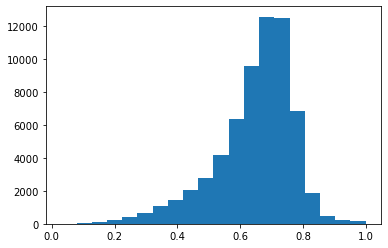

430/63672 questions >= 0.9


In [69]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(sample_cnn_article_generated_question_data.loc[:, 'best_question_score'], bins=20)
plt.show()
question_score_cutoff = 0.9
print(f'{sample_cnn_article_generated_question_data[sample_cnn_article_generated_question_data.loc[:, "best_question_score"] >= question_score_cutoff].shape[0]}/{sample_cnn_article_generated_question_data.shape[0]} questions >= {question_score_cutoff}')

OK! We have ~ 3% of generated questions that match the actual question. We should try to increase that!

### Re-train question model
Let's try to fine-tune the model using the training procedure explained [here](https://github.com/patil-suraj/question_generation#training). We should try to get the model to learn some of the basic logic required to put questions together for the CNN data before moving on prematurely to the NYT data.

In [1]:
## reload data fml
import pandas as pd
cnn_article_question_data = pd.read_csv('../../data/CNN_articles/cnn/article_question_data.tsv', sep='\t', index_col=False)
display(cnn_article_question_data.head())

,article_id,question,is_answer_absent,is_question_bad,article_text,question_tokens,article_tokens,publisher,dummy_comment_id,article_question_bleu
0,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was the amount of children murdered?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['What', 'was', 'the', 'amount', 'of', 'childr...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,0,0.017422
1,42d01e187213e86f5fe617fe32e716ff7fa3afc4,When was Pandher sentenced to death?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['When', 'was', 'Pandher', 'sentenced', 'to', ...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,1,0.017422
2,42d01e187213e86f5fe617fe32e716ff7fa3afc4,The court aquitted Moninder Singh Pandher of w...,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['The', 'court', 'aquitted', 'Moninder', 'Sing...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,2,0.020906
3,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was Moninder Singh Pandher acquitted for?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['What', 'was', 'Moninder', 'Singh', 'Pandher'...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,3,0.020906
4,42d01e187213e86f5fe617fe32e716ff7fa3afc4,Who was sentenced to death in February?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['Who', 'was', 'sentenced', 'to', 'death', 'in...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,4,0.020906


In [2]:
import os
# https://github.com/patil-suraj/question_generation/blob/master/prepare_data.py
class DataProcessor:
    """
    Process data for conversion to matrix format.
    """
    def __init__(self, tokenizer, model_type="t5", max_source_length=512, max_target_length=32):
        self.tokenizer = tokenizer
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        self.model_type = model_type
        self.hl_token = "<hl>"
        
        if model_type == "t5":
            self.sep_token = "<sep>"
        elif model_type == "bart":
            self.sep_token = "<sep>"
        else:
            self.sep_token = "[SEP]"
  
    def process(self, dataset):
        if self.model_type == "t5":
            dataset = dataset.map(self._add_eos_examples)
        
        dataset = dataset.map(self._add_special_tokens)
        dataset = dataset.map(self._convert_to_features, batched=True)
        
        return dataset
  
    def _add_eos_examples(self, example):
        example['source_text'] = example['source_text'] + " </s>"
        example['target_text'] = example['target_text'] + " </s>"
        return example
  
    def _add_special_tokens(self, example):
        example['source_text'] = example['source_text'].replace("{hl_token}", self.hl_token)    
        example['target_text'] = example['target_text'].replace("{sep_token}", self.sep_token)
        return example
  
    # tokenize the examples
    def _convert_to_features(self, example_batch):
        source_encoding = self.tokenizer.batch_encode_plus(
            example_batch['source_text'],
            max_length=self.max_source_length,
            padding='max_length',
            pad_to_max_length=True,
            truncation=True, 
        )
        target_encoding = self.tokenizer.batch_encode_plus(
            example_batch['target_text'],
            max_length=self.max_target_length,
            padding='max_length',
            pad_to_max_length=True,
            truncation=True, 
        )

        encodings = {
            'source_ids': source_encoding['input_ids'], 
            'target_ids': target_encoding['input_ids'],
            'attention_mask': source_encoding['attention_mask'],
        }

        return encodings

import torch
import numpy as np
    
def prepare_question_data(data, out_dir, tokenizer, train_pct=0.8):
    # change to clean source/target format
    clean_data = data.loc[:, ['article_text', 'question']].rename(columns={'article_text' : 'source_text', 'question' : 'target_text'})
    # split train/val
    np.random.seed(123)
    N = clean_data.shape[0]
    N_train = int(N*train_pct)
    np.random.shuffle(clean_data.values)
    clean_data_train = clean_data.iloc[:N_train, :]
    clean_data_val = clean_data.iloc[N_train:, :]
    clean_data_train_out_file = os.path.join(out_dir, 'article_question_generation_train_data.csv')
    clean_data_val_out_file = os.path.join(out_dir, 'article_question_generation_val_data.csv')
    clean_data_train.to_csv(clean_data_train_out_file, sep=',', index=False)
    clean_data_val.to_csv(clean_data_val_out_file, sep=',', index=False)
    # reload data into correct format lol
    train_data_set = nlp.load_dataset('csv', data_files=clean_data_train_out_file)
    val_data_set = nlp.load_dataset('csv', data_files=clean_data_val_out_file)
#     tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    # get max lengths
    source_text_tokens = clean_data.loc[:, 'source_text'].apply(lambda x: tokenizer.tokenize(x))
    target_text_tokens = clean_data.loc[:, 'target_text'].apply(lambda x: tokenizer.tokenize(x))
#     max_source_length = max(source_text_tokens.apply(lambda x: len(x)))
#     max_target_length = max(target_text_tokens.apply(lambda x: len(x)))
    # tmp debugging: shorten source/target
    max_source_length = 1024
    max_target_length = 64
    data_processor = DataProcessor(tokenizer=tokenizer,
                                   model_type='bert',
                                   max_source_length=max_source_length,
                                   max_target_length=max_target_length)
    train_data = data_processor.process(train_data_set)
    val_data = data_processor.process(val_data_set)
    columns = ["source_ids", "target_ids", "attention_mask"]
    train_data.set_format(type='torch', columns=columns)
    val_data.set_format(type='torch', columns=columns)
#     print(f'train data {train_data}')
    train_data_out_file = os.path.join(out_dir, 'article_question_generation_train_data.pt')
    val_data_out_file = os.path.join(out_dir, 'article_question_generation_val_data.pt')
    torch.save(train_data, train_data_out_file)
    torch.save(val_data, val_data_out_file)
    # save tokenizer?? sure
    tokenizer_out_file = os.path.join(out_dir, 'BART_tokenizer.pt')
    torch.save(tokenizer, tokenizer_out_file)

In [3]:
import nlp
import transformers
from transformers import BartTokenizer
out_dir = '../../data/CNN_articles/cnn/'
train_pct = 0.8
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
# TODO: increase vocab size to include named entities? 
# TODO: shrink data to debug training
prepare_question_data(cnn_article_question_data.copy().head(2000), out_dir, tokenizer=tokenizer, train_pct=train_pct)

Using custom data configuration default


Dataset csv downloaded and prepared to /home/ianbstew/.cache/huggingface/datasets/csv/default-9b6b2365e2270632/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.


Using custom data configuration default


Dataset csv downloaded and prepared to /home/ianbstew/.cache/huggingface/datasets/csv/default-675cf03b411ee895/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.


Now let's train a model to generate the questions.

In [4]:
# stolen from https://github.com/patil-suraj/question_generation/blob/master/run_qg.py
import sys
if('question-generation' not in sys.path):
    sys.path.append('question-generation')
import torch
# load models
from transformers import BertModel, BertTokenizer, BartTokenizer, AutoModelForSeq2SeqLM
cache_dir = '../../data/CNN_articles/cnn/model_cache/'
# model = BertModel.from_pretrained('bert-base-cased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer = torch.load('../../data/CNN_articles/cnn/BART_tokenizer.pt')
# print(len(tokenizer))
model = AutoModelForSeq2SeqLM.from_pretrained(
        'facebook/bart-base',
        cache_dir=cache_dir,
    )
model.resize_token_embeddings(len(tokenizer))
device = torch.device('cuda:0')
model.to(device)

## load data
import os
data_dir = '../../data/CNN_articles/cnn/'
train_file = os.path.join(data_dir, 'article_question_generation_train_data.pt')
val_file = os.path.join(data_dir, 'article_question_generation_val_data.pt')
train_dataset = torch.load(train_file)
val_dataset = torch.load(val_file)
train_dataset = train_dataset['train']
val_dataset = val_dataset['train']

# get max source/target len
max_source_len = len(train_dataset['source_ids'][0])
max_target_len = len(train_dataset['target_ids'][0])

# initialize data collator
import sys
if('question_generation' not in sys.path):
    sys.path.append('question_generation')
from data_collator import T2TDataCollator
model_type = 'bart'
data_collator = T2TDataCollator(
    tokenizer=tokenizer,
    model_type=model_type,
    mode="training",
    using_tpu=False
)
# #  Initialize Trainer
# need data argument class ;_;
from dataclasses import field
from typing import Dict, List, Optional
from transformers.training_args import TrainingArguments
class DataArguments(TrainingArguments):
    train_file_path: str = field(
        metadata={"help": "Path for cached train dataset"},
    )
    valid_file_path: str = field(
        metadata={"help": "Path for cached valid dataset"},
    )
    data_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Path for data files"}, 
    )
    task: Optional[str] = field(
        default=None,
        metadata={"help": "Which task 'qa', 'qg', 'e2e_qg', 'ans_ext', 'multi'. 'multi' means 'qa', 'qg', 'ans_ext' tasks"}, 
    )
    qg_format: Optional[str] = field(
        default='prepend_qg_format',
        metadata={"help": "How to format inputs for que generation, 'highlight_qg_format' or 'prepend_qg_format'"}, 
    )
    max_source_length: Optional[int] = field(
        default=512,
        metadata={"help": "Max input length for the source text"},
    )
    max_target_length: Optional[int] = field(
        default=32,
        metadata={"help": "Max input length for the target text"},
    )
    n_gpu : Optional[int] = field(
        default=1,
    )
# training_arg_dict = {
#     'train_file_path' : 'article_question_generation_train_data.pt',
#     'valid_file_path' : 'article_question_generation_val_data.pt',
#     'data_dir' : data_dir,
#     'task' : 'qg',
#     'max_source_length' : max_source_len,
#     'max_target_length' : max_target_len,
#     'n_gpu' : 1,
#     'seed' : 123,
# }
data_dir = '../../data/CNN_articles/cnn/'
out_dir = '../../data/CNN_articles/cnn/question_generation_model/'
import os
if(not os.path.exists(out_dir)):
    os.mkdir(out_dir)
training_args = DataArguments(out_dir)
training_args.train_file_path = 'article_question_generation_train_data.pt',
training_args.valid_file_path = 'article_question_generation_val_data.pt'
training_args.data_dir = data_dir
training_args.task = 'qg'
training_args.max_source_length = max_source_len
training_args.max_target_length = max_target_len
training_args.n_gpu = 1 
# training_args.device = 'cuda:1' 
training_args.seed = 123
training_args.disable_tqdm = False
training_args.local_rank = -1
training_args.output_dir = out_dir
training_args.num_train_epochs = 20
# training_args.max_steps = 1
training_args.fp16 = False
training_args.label_names = None
training_args.per_device_train_batch_size = 4
training_args.per_device_eval_batch_size = 4
# training_args.train_batch_size = 32
# training_args.eval_batch_size = 32
training_args.gradient_accumulation_steps = 4
training_args.learning_rate = 1e-4
training_args.dataloader_drop_last = False
training_args.dataloader_num_workers = 8
# default values from here lol https://github.com/huggingface/transformers/blob/49759c0cda29ab614b81e0869972c99f2edba7aa/src/transformers/training_args.py
training_args.weight_decay = 0.01
training_args.adam_beta1 = 0.9
training_args.adam_beta2 = 0.999
training_args.adam_epsilon = 1e-8
training_args.warmup_steps = 0
# limits number of checkpoints => 1 GB per optimizer file ;_;
training_args.save_total_limit = 2
model_args = {
    'label_smoothing' : 0,
}
## TODO: prevent model from saving optimizer during every 500 training steps!!
from trainer import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
#     prediction_loss_only=True,
    label_smoothing=model_args['label_smoothing'],
)

In [ ]:
## train
import torch
torch.cuda.empty_cache()
model_dir = '../../data/CNN_articles/cnn/question_generation_model/'
trainer.train(
    model_path=model_dir,
)
trainer.save_model()

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

Step,Training Loss
500,1.795577


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

Now that training is "done," let's evaluate!!

In [28]:
## load model
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
cache_dir = '../../data/CNN_articles/cnn/model_cache/'
# generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
trained_model_state_dict_file = '../../data/CNN_articles/cnn/question_generation_model/pytorch_model.bin'
trained_model_state_dict = torch.load(trained_model_state_dict_file)
generation_model.load_state_dict(trained_model_state_dict)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir=cache_dir)

In [17]:
## load evaluation data
val_data_file = '../../data/CNN_articles/cnn/article_question_generation_val_data.pt'
val_data = torch.load(val_data_file)['train']

In [87]:
## do beam search
from tqdm import tqdm
import torch
def generate_predictions(model, data, device_name='cuda:0'):
    num_beams = 4
    max_decoding_length = 64
    length_penalty = 1
    device = torch.device(device_name)
    model.to(device)
    pred_text = []
    for batch_i in tqdm(data):
        source_i = batch_i['source_ids']
        attention_i = batch_i['attention_mask']
        # fix type in case of difference
        if(type(source_i) is list):
            source_i = torch.LongTensor(source_i)
        if(type(attention_i) is list):
            attention_i = torch.Tensor(attention_i)
        output_i = model.generate(
            input_ids=source_i.to(device).reshape(1,-1), 
            attention_mask=attention_i.to(device).reshape(1,-1),
            num_beams=num_beams,
            max_length=max_decoding_length,
            length_penalty=length_penalty,
        )
        prediction = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_i]
        pred_text.extend(prediction)
    return pred_text

In [ ]:
device_name = 'cuda:0'
pred_text = generate_predictions(generation_model, val_data, device_name)

In [45]:
def compare_pred_text_with_target(data, pred_text, tokenizer):
    special_tokens = set(['<pad>', '<s>', '</s>'])
    for i, (batch_i, pred_text_i) in enumerate(zip(data, pred_text)):
        source_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['source_ids']]
        target_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['target_ids']]
        # cleanup
        source_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, source_text_i)))
        target_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, target_text_i)))
        print('*~*~*~*~*~*')
        print(f'source text = {source_text_i[:300]}...')
        print(f'target text = {target_text_i}')
        print(f'pred text = {pred_text_i}')

In [34]:
compare_pred_text_with_target(val_data, pred_text, tokenizer)

*~*~*~*~*~*
source text = J oh ann es burg  ( CNN )  --  M iff ed  by  a  visa  delay  that  led  the  Dalai  Lama  to  cancel  a  trip  to  South  Africa ,  Archbishop  Desmond  Tut u  lashed  out  at  his  government  Tuesday ,  saying  it  had  acted  worse  than  apartheid  regimes  and  had  forgotten  all  that  the  n...
target text = Who  does  the  African  National  Congress  say  should  calm  down ?
pred text = who says the government is acting worse than apartheid regime?
*~*~*~*~*~*
source text = ( CNN )  --  Verizon  has  been  touted  as  having  the  biggest ,  bad dest ,  fastest  4 G  around .  It 's  been  this  way  since  the  carrier  debuted  its  LTE  network  in  late  2010 .    But  now  that  AT & T  has  joined  the  LTE  game ,  consumers  looking  for  top  speeds  might  co...
target text = Which  network  is  currently  the  largest  in  terms  of  nationwide  coverage ?
pred text = What does the report show
*~*~*~*~*~*
source text = LOS  ANGEL ES ,  Ca

*~*~*~*~*~*
source text = ( CNN )  --  World - record  signing  Crist iano  Ronaldo  scored  on  his  debut  as  Real  Madrid  kicked  off  the  Spanish  football  season  with  a  shaky  3 - 2  victory  at  home  to  Dep ort ivo  La  Cor una  on  Saturday  night .    Crist iano  Ronaldo  celebrates  after  paying  off  a  s...
target text = What  was  the  score ?
pred text = Who kicked off Spanish football season with 3-2 win?
*~*~*~*~*~*
source text = ( CNN )  --  The  driver  who  collided  with  a  vehicle  driven  by  Olympic  swim mer  Michael  Phelps  will  be  cited  for  failure  to  stop  at  a  red  light ,  police  said  Friday .    Michael  Phelps '  black  Cadillac  Esc al ade  collided  with  another  vehicle  at  an  intersection , ...
target text = How  many  vehicles  were  involved  in  the  crash ?
pred text = What will Michael Phelps be cited for?
*~*~*~*~*~*
source text = NEW  YORK  ( CNN )  --  B idding  failed  to  meet  expectations  Saturday  on  a  uniquely 

*~*~*~*~*~*
source text = NEW  YORK  ( CNN )  --  Cool  suit ?  Check .  Ed gy  spect acles ?  Check .  Warm  vocal  chords ?  Check .    Gary  Go  uses  iPhone  apps  to  help  him  compose  new  material  --  and  provide  instant  accompan iment .    Instrument ?  Power ing  up  iPhone ...    These  days ,  British  singe...
target text = What  does  Gary  Go  use  for  musical  accompan iment ?
pred text = What nationality is Gary Go?
*~*~*~*~*~*
source text = ( CNN )  --  Paul  Harvey ,  the  legendary  radio  host  whose  career  sharing  " the  rest  of  the  story "  with  listeners  sp anned  more  than  70  years ,  has  died ,  according  to  ABC  Radio  Networks .    Paul  Harvey  received  the  Medal  of  Freedom  from  President  Bush  in  2005 ...
target text = What  was  he  best  known  for ?
pred text = who is this harvey they speak of
*~*~*~*~*~*
source text = Ber lin ,  Germany  ( CNN )    --  A  bomb  scare  that  affected  about  100  flights  at  Munich  Airport 

*~*~*~*~*~*
source text = Atlanta  ( CNN )  --  Ryan  Brun n ,  the  man  who  this  week  was  sentenced  to  life  in  prison  after  pleading  guilty  to  murdering  a  Georgia  girl ,  apparently  killed  himself  in  his  prison  cell  Thursday ,  a  corrections  spokeswoman  said .    Georgia  Department  of  Correctio...
target text = Where  was  the  little  girl  found  dead  at ?
pred text = What victim's father says he would have preferred Brunn to die?
*~*~*~*~*~*
source text = Washington  ( CNN )  --  Idaho  on  Wednesday  became  the  first  state  to  pass  a  law  saying  no  thanks  to  part  of  President  Obama 's  health  care  proposal .    The  Idaho  Health  Care  Freedom  Act  says  in  part ,  " every  person  within  the  state  of  Idaho  is  and  shall  be ...
target text = What  does  the  Idaho  law  challenge ?
pred text = what attorney general sends letters to 49 colleagues
*~*~*~*~*~*
source text = K hart ou m ,  Sudan  ( CNN )  --  South  Sudan 's  gov

*~*~*~*~*~*
source text = ( CNN )  --  The  flu  has  forced  an  early  end  to  Billy  Bob  Thornton 's  musical  tour  of  Canada ,  his  public ist  said  Saturday .    Thornton 's  public ist  says  Box masters  band  member ,  crew ,  have  flu ;  will  re join  tour  on  Tuesday .    The  news  was  reportedly  greete...
target text = who  has  been  catching  heat  for  comments  in  radio    interview ?
pred text = What night was the show in Montreal
*~*~*~*~*~*
source text = ( CNN )  --  An  armed  air man  who  allegedly  barric aded  himself  inside  a  building  on  a  Colorado  air  base  is  awaiting  sentencing  on  unrelated  charges  and  will  likely  face  additional  charges ,  the  base  said  Tuesday .    Air man  1 st  Class  Nico  Cruz  Santos ,  21 ,  su...
target text = what  is  awaiting  sentencing  on  unrelated  charges ?
pred text = where is home to the 50th Space Wing?
*~*~*~*~*~*
source text = WASHINGTON  ( CNN )    --  Former  Secretary  of  State  Co

*~*~*~*~*~*
source text = M ID DL ES BR OUGH ,  England  --  Middles b rough  have  confirmed  that  midfield ers  Fab io  Roc hem back  and  Ga iz ka  Mend iet a  and  striker  Dong  G ook  Lee  have  all  been  released .    Middles b rough  have  decided  against  taking  up  the  option  of  re - sign ing  Brazilian  mid...
target text = Who  decided  not  to  take  up  option  on  Roc hem back 's  deal ?
pred text = What did they not take up?
*~*~*~*~*~*
source text = WASHINGTON  ( CNN )    --  The  United  States  ambassador  to  Afghanistan ,  William  Wood ,  said  Friday  that  changes  in  communications  with  Afghan  military  forces  have  been  made  in  the  aftermath  of  a  disputed  U . S .  air  raid  on  an  Afghan  village .    Civil ians  are  ov...
target text = Number  of  civilians  the  airstrike  killed ?
pred text = Who said airstrike lead to 90 civilian deaths?
*~*~*~*~*~*
source text = ( CNN )  --  If  an  e - mail  popped  up  in  your  inbox  promising  

*~*~*~*~*~*
source text = MON TER EY  PARK ,  California  ( CNN )  --  Five  men  are  accused  of  starting  a  massive  Mal ibu  wildfire  at  that  destroyed  more  than  50  homes  and  forced  about  15 , 000  people  to  evacuate .    A  firefighter  works  to  contain  a  wildfire  threatening  homes  in  Mal ibu ,  C...
target text = What  helped  investigators  find  the  men ?
pred text = How many homes were destroyed because of the men?
*~*~*~*~*~*
source text = V AT ICAN  CITY ,  Vatican  ( CNN )  --  Pope  Benedict  XVI  called  for  peace  in  the  Middle  East  and  an  end  to  the  exploitation  of  children  in  the  hom ily  he  delivered  early  Thursday  during  the  annual  Christmas  Eve  Midnight  Mass  in  St .  Peter 's  Basil ica .    Pope  ...
target text = Who  quickly  tackled  a  person  as  the  Pope  was  leaving ?
pred text = who seeks to end violence?
*~*~*~*~*~*
source text = London ,  England  ( CNN )  --  A  British  auction  house  plans  to  sell

*~*~*~*~*~*
source text = SE ATTLE ,  Washington  ( CNN )  --  An  accident  involving  de - icing  solution  being  sprayed  on  an  Alaska  Airlines  plane  in  snow - covered  Seattle  sent  seven  people  to  a  hospital  Wednesday ,  airport  and  hospital  officials  said .    Emergency  vehicles  gather  around  Alask...
target text = What  happened  in  M oline ,  Illinois ?
pred text = How many crew members went to hospital?
*~*~*~*~*~*
source text = ( CNN )  --  The  Catholic  bishop  of  South  Bend ,  Indiana ,  will  not  attend  graduation  ceremonies  at  the  University  of  Notre  Dame  because  he  disagrees  with  the  stem - cell  research  and  abortion  views  of  the  commencement  speaker  --  President  Obama .    The  University...
target text = What  is  the  Bishop  saying  about  Obama ?
pred text = What did the university president say?
*~*~*~*~*~*
source text = ( CNN )    --  Sk ier  Paul  W amp ach ,  a  49 - year - old  manager  from  Chicago ,  Illinoi

*~*~*~*~*~*
source text = ( CNN )    --  Hundreds  of  U . S .  and  Afghan  soldiers  have  embarked  on  a  major  operation  against  militants  in  the  eastern  Afghan  region  of  Tor a  B ora ,  near  the  border  with  Pakistan ,  officials  have  told  CNN .    File  photo  of  the  remote  mountain  Tor a  B ora  r...
target text = Who  embarked  on  a  major  operation  in  Tor a  B ora
pred text = Where was Osama bin Laden thought to be hiding?
*~*~*~*~*~*
source text = Te hran ,  Iran  ( CNN )  --  Iran 's  Bus he hr  nuclear  power  plant  is  just  weeks  from  operating  at  full  capacity ,  the  country 's  top  nuclear  official  said  Saturday .    Fe ire id oun  Abbas i ,  the  head  of  Iran 's  Atomic  Energy  Organization ,  also  said  Tehran  has  sho...
target text = When  will  the  plant  reach  full  capacity ?
pred text = What is the full capacity of the plant?
*~*~*~*~*~*
source text = IS L AM AB AD ,  Pakistan  ( CNN )  --  The  chairman  of  the  U . S

*~*~*~*~*~*
source text = Washington  ( CNN )  --  Death  sentences  plunged  this  year  and  the  number  of  executions  continued  a  steady  decline  as  a  result  of  " growing  discomfort "  felt  by  many  Americans  on  the  application  of  capital  punishment .    Only  78  people  were  sentenced  to  lethal  in...
target text = How  many  have  been  put  to  death  in  2011 ?
pred text = When was the poll conducted?
*~*~*~*~*~*
source text = ( CNN )  --  Doctors  chose  a  woman  who  survived  a  shotgun  wound  to  her  face  as  the  first  recipient  of  a  face  transplant  after  treating  her  for  nearly  four  years .    This  image  projects  what  Connie  C ulp ,  46 ,  may  look  like  two  years  after  the  face  transplan...
target text = What  is  the  name  of  the  recipient  of  the  face  transplant ?
pred text = What did she tell CNN?
*~*~*~*~*~*
source text = AT LAN TA ,  Georgia  --  Going  back  to  work  after  my  wife  had  our  first  child  w

*~*~*~*~*~*
source text = ( CNN )  --  Authorities  Tuesday  recovered  the  body  of  an  eighth  missing  snow mob iler  buried  in  aval anches  in  southern  British  Columbia ,  a  spokesman  for  the  the  Royal  Canadian  Mount ed  Police  said .    Authorities  found  seven  bodies  a  day  after  aval anches  in  Br...
target text = Where  were  they  riding  snow m obiles ?
pred text = Whose bodies were discovered Monday?
*~*~*~*~*~*
source text = ( CNN )  --  An  Australian  pilot  landed  a  company  plane  in  the  ocean  off  Darwin  on  Friday ,  in  a  water  landing  that  prompted  comparisons  to  last  month 's  landing  of  a  US  Airways  jet  in  New  York 's  Hudson  River .    The  Australian  pilot  has  been  compared  to  U ...
target text = What  did  Australian  media  do ?
pred text = What did pilot do?
*~*~*~*~*~*
source text = Te hran ,  Iran  ( CNN )  --  Iran 's  Bus he hr  nuclear  power  plant  is  just  weeks  from  operating  at  full  capacity , 

*~*~*~*~*~*
source text = NEW  DEL HI ,  India  ( CNN )    --  About  13 , 000  employees  at  state - run  Air  India  walked  off  the  job  for  two  hours  Friday  after  the  airline  failed  to  pay  their  monthly  wage .    A  man  walks  past  the  Air  India  building  in  Mumbai .  Staff  staged  a  strike  to  pr...
target text = When  would  they  be  paid  by ?
pred text = Who is staging a flash strike?
*~*~*~*~*~*
source text = MAR ATH ON ,  Florida  ( CNN )    --  Juan  Lopez  reads  meters  with  one  eye  and  looks  for  snakes  with  the  other .  Lopez  is  a  member  of  the  " Python  Patrol ,"  a  team  of  utility  workers ,  wildlife  officials ,  park  r angers  and  police  trying  to  keep  Bur m ese  p yth o...
target text = What  have  pet  owners  been  doing ?
pred text = What does Python Patrol aim to do?
*~*~*~*~*~*
source text = ( CNN )  --  World - record  signing  Crist iano  Ronaldo  scored  on  his  debut  as  Real  Madrid  kicked  off  the  Span

*~*~*~*~*~*
source text = ( CNN )  --  A  jury  Thursday  acquitted  a  former  Louisville ,  Kentucky ,  high  school  football  coach  of  all  charges  connected  to  the  heat - related  death  of  a  player  last  year .    David  St inson  leaves  the  courtroom  Thursday  after  being  found  not  guilty  in  the  dea...
target text = Who  found  Jason  St inson  not  guilty  of  all  charges  in  the  death  of  Max  Gil pin ?
pred text = Who collapsed during practice in August 2008 and died several days later?
*~*~*~*~*~*
source text = M ID DL ES BR OUGH ,  England  --  Middles b rough  have  confirmed  that  midfield ers  Fab io  Roc hem back  and  Ga iz ka  Mend iet a  and  striker  Dong  G ook  Lee  have  all  been  released .    Middles b rough  have  decided  against  taking  up  the  option  of  re - sign ing  Brazilian  mid...
target text = Who  will  continue  at  AE K  next  season ?
pred text = What did they not take up?
*~*~*~*~*~*
source text = LOS  ANGEL ES ,  Cal

*~*~*~*~*~*
source text = ( CNN )  --  Prom inent  Chicago  defense  lawyer  Ed  G enson  said  Friday  he  intends  to  resign  as  attorney  for  embattled  Illinois  Gov .  Rod  Bl ago j ev ich  in  the  criminal  case  against  the  governor .    Illinois  Gov .  Rod  Bl ago j ev ich 's  impeachment  trial  is  scheduled...
target text = What  is  Bl ago j ev ich  accused  of ?
pred text = When will the trial start?
*~*~*~*~*~*
source text = NEW  DEL HI ,  India  ( CNN )  --  Indian  tourism  authorities  will  be  holding  English  classes  for  auto - ricks haw  drivers  in  New  Delhi  as  the  city  prepares  to  host  the  Commonwealth  Games  in  2010 .    Auto - ricks haw  drivers  are  being  taught  English  ahead  of  the  Com...
target text = What  is  the  course  of  study  for  the  8 , 000  auto - ricks haw  drivers  who  will  be  enrolled  in  the  training  program ?
pred text = How many auto-rickshaw drivers will be enrolled in the training program?
*~*~*~*~*~*
s

*~*~*~*~*~*
source text = NEW  DEL HI ,  India  ( CNN )  --  A  high  court  in  northern  India  on  Friday  acquitted  a  wealthy  businessman  facing  the  death  sentence  for  the  killing  of  a  teen  in  a  case  dubbed  " the  house  of  horrors ."    Mon inder  Singh  Pand her  was  sentenced  to  death  by  a  low...
target text = What  was  Mon inder  Singh  Pand her  acquitted  for ?
pred text = Who was sentenced to death in February?
*~*~*~*~*~*
source text = ( CNN )    --  The  Brazilian  military  said  late  Friday  it  is  calling  off  the  search  for  bodies  of  passengers  and  crew  from  the  Air  France  plane  that  crashed  into  the  Atlantic  earlier  this  month .    W reck age  from  Flight  4 47  spotted  by  search  teams  in  the  At...
target text = How  many  people  were  on  board  the  plane ?
pred text = How many of those people were found?
*~*~*~*~*~*
source text = L ONDON ,  England  ( CNN )  --  Nine  of  the  11  Pakistani  nationals  being 

*~*~*~*~*~*
source text = ( CNN )  --  About  10  men  armed  with  pistols  and  small  machine  guns  raided  a  casino  in  Switzerland  and  made  off  into  France  with  several  hundred  thousand  Swiss  franc s  in  the  early  hours  of  Sunday  morning ,  police  said .    The  men ,  dressed  in  black  clothes  a...
target text = How  many  men  raided  the  Grand  casino  Bas el
pred text = wher did the raiders go to
*~*~*~*~*~*
source text = ( CNN )  --  A  lawyer  who  left  a  videot ape  saying  Guatem alan  President  Al var o  Col om  would  be  responsible  if  anything  happened  to  him  master minded  his  own  death  last  year ,  a  special  United  Nations  commission  said  Tuesday  after  an  eight - month  investigation ....
target text = What  did  the  lawyer  leave ?
pred text = UN   commission included how many investigators?
*~*~*~*~*~*
source text = ( CNN )  --  Far rah  Faw c ett ,  whose  public  battle  with  anal  cancer  has  brought  new  attent

*~*~*~*~*~*
source text = NEW  YORK  ( CNN )  --  B idding  failed  to  meet  expectations  Saturday  on  a  uniquely  complete  skeleton  of  a  Jurassic - era  dry osaurus  --  a  long - neck ed ,  plant - eating  dinosaur  --  so  it  was  no - sale  for  the  centerpiece  at  an  auction  of  rare  skeletons ,  fossils  ...
target text = What  went  for  50 , 000 ?
pred text = What did an extinct sea creature fossil sell for?
*~*~*~*~*~*
source text = S ara ,  29 ,  has  lived  in  Miami  for  five  years ,  where  she  works  as  freelance  writer  and  film  maker .  Her  blog ,  All  Purpose  Dark ,  keeps  tabs  on  the  city 's  night life  and  restaurants ,  and  she  is  also  the  editor  of  the  Miami  edition  of  Urban Daddy . com . ...
target text = What  are  Sara 's  jobs ?
pred text = What does Sara do for work?
*~*~*~*~*~*
source text = TE HR AN ,  Iran  ( CNN )    --  Iran 's  election  authority  has  rejected  claims  of  voting  irregularities  by  a  defeated

*~*~*~*~*~*
source text = PAR IS ,  France  ( CNN )    --  French  Culture  Minister  Freder ic  M itter rand  said  Thursday  he  will  not  resign  over  accounts  in  a  book  he  wrote  in  2005  about  paying  to  have  sex  with  " boys "  in  Thailand .    Freder ic  M itter rand  admitted  to  paying  for  sex  with ...
target text = who  came  to  the  defense  of  Pol anski  after  his  arrest ?
pred text = WHo wrote the book?
*~*~*~*~*~*
source text = NEW  DEL HI ,  India  ( CNN )  --  Indian  tourism  authorities  will  be  holding  English  classes  for  auto - ricks haw  drivers  in  New  Delhi  as  the  city  prepares  to  host  the  Commonwealth  Games  in  2010 .    Auto - ricks haw  drivers  are  being  taught  English  ahead  of  the  Com...
target text = In  what  city  will  the  Commonwealth  Games  be  expected  to  host  100 , 000  tourists ?
pred text = How many auto-rickshaw drivers will be enrolled in the training program?
*~*~*~*~*~*
source text = ( CNN )  -

*~*~*~*~*~*
source text = L ONDON ,  England  ( CNN )  --  Israeli  military  action  in  Gaza  is  comparable  to  that  of  German  soldiers  during  the  Holocaust ,  a  Jewish  UK  lawmaker  whose  family  suffered  at  the  hands  of  the  Nazis  has  claimed .    A  protester  confronts  police  in  London  last  weeke...
target text = What  type  of  choice  has  Hamas  made
pred text = Where was the attack?
*~*~*~*~*~*
source text = ( CNN )  --  About  10  men  armed  with  pistols  and  small  machine  guns  raided  a  casino  in  Switzerland  and  made  off  into  France  with  several  hundred  thousand  Swiss  franc s  in  the  early  hours  of  Sunday  morning ,  police  said .    The  men ,  dressed  in  black  clothes  a...
target text = How  far  away  is  France  from  the  casino
pred text = wher did the raiders go to
*~*~*~*~*~*
source text = ( CNN )  --  There 's  a  photo  of  the  Jackson  family  on  the  cover  of  the  September  24 ,  1971 ,  issue  of  Life  

*~*~*~*~*~*
source text = Washington  ( CNN )  --  Idaho  on  Wednesday  became  the  first  state  to  pass  a  law  saying  no  thanks  to  part  of  President  Obama 's  health  care  proposal .    The  Idaho  Health  Care  Freedom  Act  says  in  part ,  " every  person  within  the  state  of  Idaho  is  and  shall  be ...
target text = How  many  colleagues  received  letters  from  Florida  att orn y  general ?
pred text = what attorney general sends letters to 49 colleagues
*~*~*~*~*~*
source text = ( CNN )  --  President  Obama ,  Vice  President  Joe  Biden  and  other  top  Democrats  are  heading  back  to  school  Tuesday ,  in  hopes  of  convincing  first - time  voters  from  the  2008  election  to  vote  again  in  2010 .    The  president  is  scheduled  to  headline  a  Democratic  ...
target text = what  percent  were  first  timers  casting  ballots
pred text = where do the democrats face tough odds
*~*~*~*~*~*
source text = ( PE OPLE . com )  --  There 's  anothe

Good predictions:

- target = `what is included in Jackson's trust` vs. predicted = `who is included in Michael Jackson's trust`
- target = `What  object  did  he  compare  his  dad  to` vs. predicted = `What did he describe his dad as?`
- target = `What  method  of  execution  did  Powell  reject` vs. predicted = `What was the execution method used`
- target = `Can  you  name  the  manager` vs. predicted = `Who was the onetime manager?`

Bad predictions: 

- target = `How many people will attend Comic-con this year` vs. predicted = `Who stars in Zombieland`
- target = `Who was found dead` vs. predicted `What victim's father says he would have preferred Brunn to die?`
- target = `Who  was  rejected  through  home  state  courtesy ` vs. `Who degraded the country`
- target = `What  reson ated  loudly  regarding  Bill  Clinton ` vs. `Age of Tubbs Jones when she died`

Some of the generated questions are likely still valid, but they do not match the expected question. 

What are the BLEU scores of the generated questions?

In [57]:
# compute BLEU scores
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
def compute_text_match_score(txt_1, txt_2, weights):
    score = sentence_bleu([txt_1], txt_2, weights=weights)
    return score
def compute_all_match_scores(data, pred_text, weights):
    special_tokens = set(['<pad>', '<s>', '</s>'])
    pred_text_match_scores = []
    for i, (batch_i, pred_text_i) in enumerate(zip(data, pred_text)):
        source_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['source_ids']]
        target_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['target_ids']]
        # cleanup
        source_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, source_text_i)))
        target_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, target_text_i)))
        match_score_i = compute_text_match_score(target_text_i, pred_text_i, weights=weights)
        pred_text_match_scores.append(match_score_i)
    pred_text_match_scores = np.array(pred_text_match_scores)
    return pred_text_match_scores

In [ ]:
## get val data text for later
val_target_text_combined = []
for i, (batch_i) in enumerate(val_data):
    target_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['target_ids']]
    target_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, target_text_i)))
    # save target text for later qualitative comparisons
    val_target_text_combined.append(target_text_i)

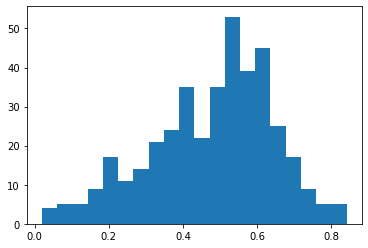

In [46]:
bleu_weights = [1.0, 0., 0., 0.]
pred_text_match_scores = compute_all_match_scores(val_data, pred_text, bleu_weights)
## plot scores
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(pred_text_match_scores, bins=20)
plt.show()

OK! The overlap actually isn't terrible at first glance, although we've seen [before](test_article_question_overlap.ipynb) that 0.9 is the cutoff for "correct" matches and this distribution doesn't look too great from that perspective.

In [47]:
## show best-scoring pairs
import pandas as pd
pred_text_scores = pd.DataFrame([val_target_text_combined, pred_text, pred_text_match_scores], index=['pred_text', 'target_text', 'match_score']).transpose()
pred_text_scores.sort_values('match_score', inplace=True, ascending=False)
display(pred_text_scores.head(20))

,pred_text,target_text,match_score
97,What does spokeswoman say about trial ?,What did the spokeswoman say about the case?,0.840909
2,What is included in Jackson 's trust ?,Who is included in Michael Jackson's trust?,0.837209
66,What did Gerrard admitted ?,What did Gerrard admit doing?,0.832849
215,What offers inst al ment plans ?,What are clients using to pay fees?,0.8
135,Which interstate was shut down ?,What interstate did the crash shut down?,0.8
260,What is home to the Space Wing ?,where is home to the 50th Space Wing?,0.78919
323,What do republic ans call Sonia S otom ...,What do some Republicans call Sonia Sotomayor?,0.780003
154,What strain has sick ened hundreds ?,What strain has caused hundreds to fall ill?,0.772727
7,Where did the train bombing occur ?,What number of people died in the bombing?,0.761905
249,What was Jackson looking to control ?,Who is looking for control in the article?,0.761905


- Question match: 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 = 50%

For such a small amount of data used in training, these results are actually pretty impressive! The question generation model must learn quickly.

After hard-coding the training process, we've trained the model on the full dataset. Let's see how the generation goes!!

In [89]:
## load model
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
cache_dir = '../../data/CNN_articles/cnn/model_cache/'
generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
# trained_model_state_dict_file = '../../data/CNN_articles/cnn/question_generation_model/pytorch_model.bin' # original/final model??
trained_model_state_dict_file = '../../data/CNN_articles/cnn/question_generation_model/checkpoint-120500/pytorch_model.bin' # checkpoint model
trained_model_state_dict = torch.load(trained_model_state_dict_file)
generation_model.load_state_dict(trained_model_state_dict)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
## load evaluation data
val_data_file = '../../data/CNN_articles/cnn/article_question_generation_val_data.pt'
val_data = torch.load(val_data_file)['train']

In [66]:
## TODO: try a smaller encoder/decoder?
# from transformers import AutoModelForSeq2SeqLM
# cache_dir = '../../data/CNN_articles/cnn/model_cache/'
# mini_generation_model = AutoModelForSeq2SeqLM.from_pretrained('sshleifer/bart-tiny-random', cache_dir=cache_dir)
# print(mini_generation_model)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 24, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 24, padding_idx=1)
      (embed_positions): LearnedPositionalEmbedding(1026, 24, padding_idx=1)
      (layers): ModuleList(
        (0): EncoderLayer(
          (self_attn): Attention(
            (k_proj): Linear(in_features=24, out_features=24, bias=True)
            (v_proj): Linear(in_features=24, out_features=24, bias=True)
            (q_proj): Linear(in_features=24, out_features=24, bias=True)
            (out_proj): Linear(in_features=24, out_features=24, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=24, out_features=16, bias=True)
          (fc2): Linear(in_features=16, out_features=24, bias=True)
          (final_layer_norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        )
        (1): EncoderLaye

In [84]:
import numpy as np
mini_val_data_size = 100
mini_val_data = val_data.select(np.array(list(range(mini_val_data_size))))
print(mini_val_data)

Dataset(features: {'source_text': Value(dtype='string', id=None), 'target_text': Value(dtype='string', id=None), 'source_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'target_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 100)


In [90]:
device_name = 'cpu'
pred_text = generate_predictions(generation_model, mini_val_data, device_name)

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


In [91]:
## evaluate 
compare_pred_text_with_target(mini_val_data, pred_text)

*~*~*~*~*~*
source text = ( CNN )  --  The  parents  of  a  missing  10 - month - old  Missouri  girl  late  Thursday  indicated  they  are  cooperating  with  detectives ,  counter  to  what  police  said  earlier  in  the  evening ,  a  relative  said .    A  woman  who  identified  herself  as  Ashley  Irwin ,  sister  of...
target text = Lisa  Irwin 's  mother  says  the  girl  is  what ?
pred text = Do police say her parents are suspects?
*~*~*~*~*~*
source text = H AR ARE ,  Zimbabwe  ( CNN )    --  Zimbabwe 's  prime  minister  believes  the  driver  of  the  truck  that  struck  his  car ,  killing  his  wife ,  deliberately  drove  toward  them ,  his  party  told  CNN .    Morgan  Ts v ang ir ai  leaves  the  hospital  Saturday  after  being  treated  fo...
target text = What  type  of  accident  was  Morgan  Ts v ang ir ai  in ?
pred text = Where will Morgan Tsvangirai go on Wednesday?
*~*~*~*~*~*
source text = ( CNN )  --  The  investigation  of  the  E .  coli  outbreak  l

*~*~*~*~*~*
source text = LOS  ANGEL ES ,  California  ( CNN )  --  As  the  man  in  the  Dodgers  jersey  walked  quickly  around  the  perimeter  of  the  infield ,  fans  poured  down  from  the  ble achers  begging  for  aut ographs .    Pit bull  says  he  learns  from  setbacks :  " Usually  the  negatives  turned  ou...
target text = Wh ose  his  new  album  debuted  in  Top  10 ?
pred text = Who has Cuban heritage?
*~*~*~*~*~*
source text = ( CNN )  --  Capt .  Ches ley  S ull en berger ,  the  hero  pilot  who  safely  landed  a  full  passenger  jet  in  the  Hudson  River ,  was  once  again  honored  with  cheers  and  applause  Tuesday  during  a  ceremony  for  him  hosted  by  the  governor  of  his  home  state .    Gov .  Arno...
target text = Who  safely  landed  flight  15 49 ?
pred text = which is the name of the pilot?
*~*~*~*~*~*
source text = ( CNN )  --  An  Arizona  couple  who  wanted  to  adopt  a  woman 's  baby  know  more  than  they 're  saying  about  t

*~*~*~*~*~*
source text = ( CNN )  --  A  surrogate  mother  gave  birth  to  twin  girls  for  Sarah  Jessica  Parker  and  Matthew  Bro der ick ,  a  public ist  for  the  couple  said .    Sarah  Jessica  Parker  and  Matthew  Bro der ick  are  the  new  parents  of  twin  daughters .    " The  babies  are  doing  beautif...
target text = For  how  long  has  the  couple  been  married ?
pred text = Who had twin daughters?
*~*~*~*~*~*
source text = ( CNN )  --  Two  human - rights  activists  were  shot  and  killed  in  Kenya 's  capital ,  N airo bi ,  on  Thursday  evening ,  leading  a  U . N .  investigator  to  call  for  an  independent  investigation  to  prove  that  Kenyan  police  were  not  involved .    U . N .  inv es it g ator  ...
target text = Who  called  for  the  inquiry ?
pred text = What city did one student get fatally shot?
*~*~*~*~*~*
source text = ( CNN )  --  James  Cameron  unveiled  his  much - hyp ed ,  wildly - anticipated  3 D  sci - fi  epic  " Av at

*~*~*~*~*~*
source text = K abul ,  Afghanistan  ( CNN )  --  An  attack  in  which  the  Taliban  claimed  to  have  infiltrated  key  government  sites  in  downtown  Kabul  killed  at  least  five  people  Monday  morning ,  hospital  and  government  officials  said .    Among  the  five  were  two  policemen  and  one  ...
target text = How  many  insurgents  are  dead ?
pred text = where does the taliban enter?
*~*~*~*~*~*
source text = WASHINGTON  ( CNN )  --  Democratic  presidential  front - runner  Sen .  Barack  Obama  is  in  excellent  health ,  according  to  a  statement  from  his  doctor ,  released  by  the  campaign .    Besides  being  an  " inter mitt ent  smoker ,"  Sen .  Barack  Obama  is  in  excellent  health , ...
target text = Who  is  a  smoker ?
pred text = Who released his records last week?
*~*~*~*~*~*
source text = LOS  ANGEL ES ,  California  ( CNN )    --  A  1965  Volkswagen  van  stolen  35  years  ago  in  Spokane ,  Washington ,  was  found  by  c

*~*~*~*~*~*
source text = ( CNN )  --  The  U . S .  Coast  Guard  on  Thursday  is  searching  for  two  fishermen  missing  after  a  commercial  fishing  vessel  went  down  in  remote ,  treacherous  waters  off  the  Ale ut ian  Islands  about  1 , 400  miles  southwest  of  Anchorage ,  Alaska .    The  fishing  vessel...
target text = What  is  the  name  of  the  fishing  vessel ?
pred text = What is "The Katmai"?
*~*~*~*~*~*
source text = BER LIN ,  Germany  ( CNN )    --  Women 's  boxing  will  be  included  at  the  2012  Olympic  Games  in  London ,  the  president  of  the  International  Olympic  Committee  announced  Thursday .    Germany 's  In a  Men zer ,  left ,  fights  American  Franc hes ca  Al can ter  during  a  W IB ...
target text = Which  sport  will  be  included  in  2012  o lymp ics ?
pred text = Where were the games being held in 2012?
*~*~*~*~*~*
source text = A UR OR A ,  Colorado  ( CNN )  --  The  Atlanta  lawyer  with  tuberculosis  who  caused  an 

At first glance, the generated questions look plausible even if they're different from the target questions (e.g. swapping `when` questions for `what` questions about the same content).

Are the generated and target questions identical? We label yes/no.

- Question match: 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 = 8%

This is bad! Is the model overfitting to the training data? We won't know without looking at the train/validation losses.

What is overall distribution of question scores, and is this less bad than what we saw before?

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

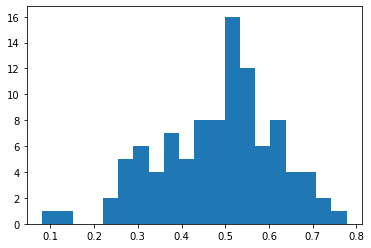

In [92]:
bleu_weights = [1.0, 0.0, 0.0, 0.0]
question_match_scores = compute_all_match_scores(mini_val_data, pred_text, bleu_weights)
## show distribution
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(question_match_scores, bins=20)
plt.show()

Compared to the original distribution, it seems like we have a slightly more normal and less skewed distribution (higher mean)?

In [93]:
## rate the top-k questions
## get val data text for later
val_target_text_combined = []
special_tokens = set(['<pad>', '<s>', '</s>'])
for i, (batch_i) in enumerate(mini_val_data):
    target_text_i = [tokenizer.decode(x, skip_special_tokens=True) for x in batch_i['target_ids']]
    target_text_i = ' '.join(list(filter(lambda x: x not in special_tokens, target_text_i)))
    # save target text for later qualitative comparisons
    val_target_text_combined.append(target_text_i)
import pandas as pd
pred_text_scores = pd.DataFrame([val_target_text_combined, pred_text, question_match_scores], index=['pred_text', 'target_text', 'match_score']).transpose()
pred_text_scores.sort_values('match_score', inplace=True, ascending=False)
display(pred_text_scores.head(20))

,pred_text,target_text,match_score
95,What did the administration plan ?,What had administration planned?,0.777215
92,Was the plane damaged ?,Was there any damages?,0.720059
56,When did Hollow ay disappear ?,Country where Holloway disappeared?,0.714286
74,what does Ring leader Greg Bell ch ambers ...,what happened to nearly every major golf brand...,0.693548
4,Where is the Carnival ?,What age is the dancer?,0.686906
35,What age is Steven Hutch ison ?,How long did Hutchison serve in the army?,0.682927
94,What has meditation helped to do ?,What is the third most popular religion in the...,0.68
7,what does the Video showed ?,What is the date of the incident?,0.666667
52,what does the policy undermine,What does the new TSA guidelines require?,0.658537
97,What do critics call it ?,Who was the bill inspired by?,0.655172


Even the high-scoring questions are not great and seem to have spurious connections (`Holloway` is match, `when` vs. `where` is not match).

TODO: What is the difference in training/validation loss?

We can't get the raw file open BUT we see using Tensorboard that the training loss does decrease monotonically.

- To replicate: on server `tensorboard --logdir=scripts/data_processing/runs/Dec02_01-00-39_lit1000/`; on local `ssh -N -f -L` to connect remotely

### Test question generation: user-generated questions
Let's see how well we can generate the same questions that people ask on NYT articles. 

H0: "Normal" generation model will struggle to predict user-generated comments, even after significant training, because the model lacks (1) theory of mind (2) shared common background/expectations with readers, which may be captured by additional background information (experience, geography, intent, etc.).

In [20]:
## load data
import os
import pandas as pd
import re
def load_all_scraped_articles(data_dir):
    article_files = list(map(lambda x: os.path.join(data_dir, x), os.listdir(data_dir)))
    article_data = pd.concat(list(map(lambda x: pd.read_csv(x, sep='\t', index_col=False), article_files)), axis=0)
    article_id_matcher = re.compile('(?<=article_)[0-9a-zA-Z]+(?=\.tsv)')
    article_ids = list(map(lambda x: article_id_matcher.search(x).group(0), article_files))
    article_data = article_data.assign(**{
        'article_id' : article_ids
    })
    return article_data
def clean_text_body(txt, word_tokenizer, matcher_pairs):
    clean_txt = ' '.join(word_tokenizer.tokenize(txt))
    for matcher_i, sub_i in matcher_pairs:
        clean_txt = matcher_i.sub(sub_i, clean_txt)
    return clean_txt
from nltk.tokenize import sent_tokenize, WordPunctTokenizer
def load_all_comment_questions(comment_dir, comment_month_years=[('April', '2018')]):
    comment_files = list(map(lambda x: f'Comments{x[0]}{x[1]}.csv', comment_month_years))
    comment_files = list(map(lambda x: os.path.join(comment_dir, x), comment_files))
    comment_data = []
    for comment_file_i in comment_files:
        comment_data_i = pd.read_csv(comment_file_i, sep=',', index_col=False, usecols=['articleID', 'approveDate', 'commentBody', 'commentType', 'parentID', 'userLocation', 'userID', 'userDisplayName'])
        comment_data.append(comment_data_i)
    comment_data = pd.concat(comment_data, axis=0)
    # remove duplicates? OK
    comment_data.drop_duplicates(['articleID', 'commentBody'], inplace=True)
    # clean text => fix punctuation without spaces and HTML
#     html_matcher = re.compile('<.+>')
    matcher_pairs = [(re.compile('<.+>'), ' <HTML> '), 
                     (re.compile('\.{2,}'), '.'),
                     (re.compile(' \- '), '-'), 
                     (re.compile(' ([\.\?\!,\'\"]+)'), '\\1'), 
                     (re.compile('([\']) (?=[a-z])'), '\\1'), # fix contraction spacing
                     (re.compile('(\() '), '\\1'), (re.compile(' (\))'), '\\1')]
    word_tokenizer = WordPunctTokenizer()
    comment_data = comment_data.assign(**{
        'commentBody' : comment_data.loc[:, 'commentBody'].apply(lambda x: clean_text_body(x, word_tokenizer, matcher_pairs))
    })
#     a_1 = html_matcher.sub('<HTML>', a)
#     # fix spaces before punctuation
#     a_1 = ' '.join(word_tokenizer.tokenize(a_1))
#     for punct_matcher_i, punct_i in punct_matchers:
#         a_1 = punct_matcher_i.sub(punct_i, a_1)
    # find questions
    question_matcher = re.compile('\?$')
    comment_data = comment_data.assign(**{
        'comment_questions' : comment_data.loc[:, 'commentBody'].apply(lambda x: list(filter(lambda y: question_matcher.search(y) is not None, sent_tokenize(x))))
    })
    # convert to question data (one row/question)
    question_data = []
    question_cols = ['approveDate', 'articleID', 'commentBody', 'commentType', 'parentID', 'userID', 'userLocation', 'userDisplayName']
    for idx_i, data_i in comment_data.iterrows():
        for question_j in data_i.loc['comment_questions']:
            question_data.append(pd.Series(data_i.loc[question_cols].append(pd.Series([question_j], index=['question']))))
    question_data = pd.concat(question_data, axis=1).transpose()
    question_data.rename(columns={'articleID':'article_id'}, inplace=True)
    ## TODO: clean short/malformed questions
    min_question_len = 6
    question_data = question_data.assign(**{
        'question_len' : question_data.loc[:, 'question'].apply(lambda x: len(word_tokenizer.tokenize(x)))
    })
    question_data = question_data[question_data.loc[:, 'question_len'] >= min_question_len]
#     html_matcher = re.compile('<[^>]+>.+<[^>]+/>')
#     html_matcher = re.compile('<.+>')
#     question_data = question_data.assign(**{
#         'comment_question' : question_data.loc[:, 'comment_question'].apply(lambda x: html_matcher.sub('<HTML>', x))
#     })
    ## 
    return question_data
nyt_data_dir = '../../data/NYT_scrape/'
nyt_article_data = load_all_scraped_articles(nyt_data_dir)
nyt_comment_dir = '../../data/nyt_comments/'
comment_month_years = [('April', '2018')]
nyt_question_data = load_all_comment_questions(nyt_comment_dir, comment_month_years=comment_month_years)

In [21]:
print(f'{nyt_question_data.shape[0]} questions')
display(nyt_question_data.head())
display(nyt_question_data.sort_values('question_len', inplace=False, ascending=True).loc[:, 'question'].head(10).values)

70899 questions


,approveDate,article_id,commentBody,commentType,parentID,userID,userLocation,userDisplayName,question,question_len
0,1524594282,5adf6684068401528a2aa69b,How could the league possibly refuse this offer?,comment,0,4.65667e+07,San Francisco,Christopher Rillo,How could the league possibly refuse this offer?,9
1,1524593431,5adf6684068401528a2aa69b,Could the cheerleaders join the Actors' Equity...,comment,0,8.19396e+07,"Phoenix, AZ",Stephen,Could the cheerleaders join the Actors' Equity...,15
2,1524583914,5adf4626068401528a2aa628,Did this remind me of Joyce? <HTML> Well don...,comment,0,3.8909e+07,"BK, NY",Dustin R.,Did this remind me of Joyce?,7
5,1524591916,5adf40d2068401528a2aa619,One has to wonder-does Trump have even a basic...,comment,0,7.69947e+07,CA,John Adams,One has to wonder-does Trump have even a basic...,17
6,1524591916,5adf40d2068401528a2aa619,Truly the most disgusting display of faux brom...,comment,0,5.69492e+07,old lyme ct.,susan mccall,"Why does trump do that aggressive, pull victim...",14


array(['I am so malleable that?', 'Would you do this favour?',
       'Orba multi-racial one?', 'So who are the racist?',
       'Could you be more specific?', 'How is that fiscally responsible?',
       'Why is this so hard?', 'Will he ever fess up?',
       'What can possibly go wrong?', 'David, are you serious?'],
      dtype=object)

After preparing data and training, let's see what questions the model has learned to generate.

In [1]:
## load model
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
cache_dir = '../../data/nyt_comments/model_cache/'
generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
trained_model_state_dict_file = '../../data/nyt_comments/question_generation_model/checkpoint-96000/pytorch_model.bin' # checkpoint model
trained_model_state_dict = torch.load(trained_model_state_dict_file)
generation_model.load_state_dict(trained_model_state_dict)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
## load evaluation data
val_data_file = '../../data/nyt_comments/NYT_question_data_val_data.pt'
val_data = torch.load(val_data_file)['train']

In [2]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import generate_predictions
device_name = 'cuda:0'
pred_text = generate_predictions(generation_model, val_data, tokenizer, device_name)

  0%|          | 0/9612 [00:00<?, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
100%|██████████| 9612/9612 [24:32<00:00,  6.53it/s]


How good are these guesses in general? We'll use BLEU score as an approximate per usual.

In [3]:
val_data['target_text']

['These officers will say they feared for their lives but should we have police officers who are so easily frightened?',
 'What kind of people live in, govern, Mississippi?',
 'Why not bring up the comparison to cigarettes?',
 'I thought the business model for companies like Facebook and Google is to reduce all human interaction however personal into an information-based commodity?',
 'I ’ m not necessarily unhappy that he did this but WHAT exact is the mission that was accomplished?',
 'What is the benefit of rolling back the environmental restrictions?',
 'I am more interested in why the “ Infotainer ” needed Mike “ The Fixer ” Cohen ’ s services?',
 "What is the evidence that most NYC residents don't have cars?",
 'And cost us suffering Americans how much?',
 "So I'm all about strengthening them, as where would we be without them?",
 'He asked to use the bathroom?',
 'The Ford Escape with its puny turbocharged four-cylinder engine?',
 'How much money have Canadian Politicians taken 

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

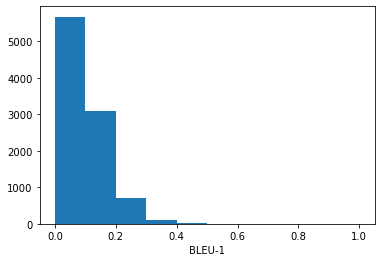

In [9]:
from nltk.tokenize import WordPunctTokenizer
from data_helpers import compute_text_bleu
word_tokenizer = WordPunctTokenizer()
target_text_tokens = list(map(word_tokenizer.tokenize, val_data['target_text']))
pred_text_tokens = list(map(word_tokenizer.tokenize, pred_text))
bleu_weights = [1.0, 0., 0., 0.]
pred_text_bleu_scores = list(map(lambda x: compute_text_bleu(x[0], x[1], weights=bleu_weights), zip(target_text_tokens, pred_text_tokens)))
# plot distribution
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(pred_text_bleu_scores)
plt.xlabel('BLEU-1')
plt.show()

OK! It looks like the overlap is pretty bad overall.

In [10]:
device_name = 'cpu'
generation_model.to(device_name)
torch.cuda.empty_cache()

In [11]:
import numpy as np
mini_val_data_size = 100
mini_val_data = val_data.select(np.array(list(range(mini_val_data_size))))
mini_pred_text = pred_text[:mini_val_data_size]

In [12]:
## look at questions manually first
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import compare_pred_text_with_target
compare_pred_text_with_target(mini_val_data, mini_pred_text, tokenizer)

*~*~*~*~*~*
source text = New  York  City  police  officers  shot  and  killed  a  black  man  who  was  known  to  be  mentally  ill  on  a  Brooklyn  street  corner  on  Wednesday  afternoon  after  he  pointed  what  the  officers  believed  was  a  gun  at  them ,  the  authorities  said .  The  object ,  however ,  turn...
target text = These  officers  will  say  they  feared  for  their  lives  but  should  we  have  police  officers  who  are  so  easily  frightened ?
pred text = Why do people act so strangely?
*~*~*~*~*~*
source text = J ACK SON ,  Miss .  --  On  the  witness  stand  and  under  pressure ,  Frank  Shaw ,  the  w arden  of  the  East  Mississippi  Correctional  Facility ,  could  not  guarantee  that  the  prison  was  capable  of  performing  its  most  basic  function .  Asked  if  the  guards  were  supposed  t...
target text = What  kind  of  people  live  in ,  govern ,  Mississippi ?
pred text = This is some sick nightmare out of the eighteenth century, 

*~*~*~*~*~*
source text = As  an  apartment  tower  rises  in  Murray  Hill  overlooking  the  East  River ,  the  reins  of  one  of  New  York 's  highest  profile  family - owned  development  firms  are  being  passed  from  one  generation  to  the  next .  The  building  is  6 85  First  Avenue ,  a  42 - story ,  obs ...
target text = Is  9  West  57 th  occupancy  at "  70  percent  today "  or ,  as  written  earlier  in  article "  much  of  it  is  currently  vacant "?
pred text = At 89 does this man have any moral compass?
*~*~*~*~*~*
source text = We  are  now  in  the  midst  of  an  epic  clash  between  Donald  Trump  and  fired  F .  B .  I .  Director  James  Comey ,  neither  of  whom  I  hold  in  high  esteem ,  both  men  with  raging  eg os  and  questionable  motives .  The  depth  of  my  contempt  differs  between  the  two ,  bu...
target text = Honestly ,  why  do  you  believe  that  the  person  who  got  less  votes ,  less  state  delegates ,  less  supe

*~*~*~*~*~*
source text = Step hon  Clark ,  the  unarmed  black  man  who  was  fatally  shot  last  week  by  Sacramento  police  officers ,  was  struck  eight  times ,  mostly  in  his  back ,  according  to  an  independent  autopsy  released  Friday ,  raising  significant  questions  about  the  police  account  that ...
target text = Did  they  find  the  crow bar ?
pred text = What is wrong with American law enforcement?
*~*~*~*~*~*
source text = SE OU L ,  South  Korea  --  North  Korea 's  leader ,  Kim  Jong - un ,  announced  early  Saturday  that  his  country  no  longer  needed  to  test  nuclear  weapons  or  long - range  missiles  and  would  close  a  nuclear  test  site ."  The  nuclear  test  site  has  done  its  job ,"  Mr .  ...
target text = You  mean  � �  rocket  man  � �  worked ?
pred text = Is it me, or do I smell more gaslighting from NOPOTUS?
*~*~*~*~*~*
source text = One  of  the  more  dist ressing  truths  of  America 's  opioid  epidemic ,  which  n

*~*~*~*~*~*
source text = WASHINGTON  --  President  Trump ,  in  a  sharp  reversal ,  told  a  gathering  of  farm - state  lawmakers  and  governors  on  Thursday  morning  that  the  United  States  was  looking  into  rejo ining  a  multic ount ry  trade  agreement  known  as  the  Trans - Pacific  Partnership ,  a  dea...
target text = Does  anyone  honestly  believe  that  the  United  States  may  simply  w alt z  back  in  to  the  TPP ?
pred text = Why would any reversal of dt's be a surprise?
*~*~*~*~*~*
source text = President  Trump  has  long  had  ties  to  the  nation 's  major  media  players .  But  his  connections  with  the  country 's  largest  tabloid  publisher ,  American  Media  Inc .,  run  deeper  than  most .  A  former  top  executive  of  Mr .  Trump 's  casino  business  sits  on  A .  M .  I...
target text = The  Constitution  protects  speech ,  but  does  it  protect "  not  speech "?
pred text = Does anyone know where else I can see Hollywood stars w

*~*~*~*~*~*
source text = � �  This  is  the  nightmare  scenario .  Everybody  figured  he  � �  d  just  hang  in  there  till  after  the  election . � �  TH OM AS  M .  DAV IS  III ,  a  former  Republican  representative  from  Virginia ,  on  the  fallout  from  the  surprise  announcement  by  Speaker  Paul  D .  Ryan...
target text = Has  anyone  considered  he  timed  his  retirement  announcement  to  scramble  the  far  rights  rise  to  power ?
pred text = Why are the benefits of Ryan leaving not being reported?
*~*~*~*~*~*
source text = WASHINGTON  --  The  Trump  administration  imposed  new  sanctions  on  seven  of  Russia 's  richest  men  and  17  top  government  officials  on  Friday  in  the  latest  effort  to  punish  President  Vladimir  V .  Putin 's  inner  circle  for  interference  in  the  2016  election  and  other...
target text = Do  we  have  the "  Dr  J ek yll  and  Mr  Hyde "  in  the  WH ?
pred text = What is changing, how much will it cost the targ

*~*~*~*~*~*
source text = President  Trump  escalated  his  verbal  f us ill ade  against  immigrants  this  week  by  announcing  a  foolish  plan  to  deploy  troops  along  the  Mexican  border .  Such  a  move  has  at  best  a  ten uous  basis  in  law  and  none  in  logic ,  and  it  will  burn  through  federal  fund...
target text = Are  there  no  checks  and  balances  in  this  crazy  world  where  the  GOP  has  all  the  power ?
pred text = Why are we debating Russia's involvement in our democracy?
*~*~*~*~*~*
source text = Victoria  T oline  would  h unch  over  the  kitchen  table ,  steady  her  hands  and  draw  a  bead  of  liquid  from  a  v ial  with  a  small  dro pper .  It  was  a  delicate  operation  that  had  become  a  daily  routine  --  extracting  ever  tin ier  doses  of  the  antidepressant  she  ha...
target text = Michael ,  can  you  say  a  bit  about  what  psych odynamic  psych otherapy  is ?
pred text = What about the increased stress in the wor

The predicted questions almost always miss the mark, although they seem to match to topic of each article.

The model does seem to repeat itself a lot:

- `How to win an argument about guns?`
- `Why would anyone debase themselves so grotesquely?`

We should try to increase the width or temperature of the beam search to avoid local optima when generating questions.

Despite our data filtering, a lot of the target questions are not super useful, especially the short ones (`Who  would  you  buy  a  car  from ?`).

What if we make the prediction task a little easier? 

Let's compute the maximium overlap score between the generated question and all questions for a given article, and use that as our test score.

In [24]:
import numpy as np
from data_helpers import generate_predictions, compute_text_bleu
from nltk.tokenize import WordPunctTokenizer
from tqdm import tqdm
import re
def clean_text(text, matcher_pairs):
    for matcher, sub in matcher_pairs:
        text = matcher.sub(sub, text)
    return text
def compute_max_overlap(model, batch_data, raw_data, tokenizer, device_name='cpu'):
    # assume that batch data and raw data align
    article_ids = raw_data.loc[:, 'article_id'].unique()
    score_weights = [1.0, 0., 0., 0.]
    score_data = []
    word_tokenizer = WordPunctTokenizer()
    matcher_pairs= [
        (re.compile('<HTML>'), ' ')
    ]
    for article_id_i in tqdm(article_ids):
        idx_i = np.where(raw_data.loc[:, 'article_id'] == article_id_i)[0]
        batch_data_i = batch_data.select(idx_i)
        batch_data_to_generate_i = batch_data.select([idx_i[0]])
        # generate question for the article
        pred_text_i = generate_predictions(model, batch_data_to_generate_i, tokenizer, device_name=device_name)
        pred_text_i = clean_text(pred_text_i[0], matcher_pairs)
        # convert to tokens
        pred_text_tokens_i = word_tokenizer.tokenize(pred_text_i)
        # compute overlap score for all target
        overlap_scores_i = []
        all_target_text_i = []
        for batch_data_j in batch_data_i:
            target_i = batch_data_j['target_ids']
            target_text_i = tokenizer.decode(target_i, skip_special_tokens=True)
            target_text_i = clean_text(target_text_i, matcher_pairs)
            target_text_tokens_i = word_tokenizer.tokenize(target_text_i)
            overlap_score_i = compute_text_bleu(target_text_tokens_i, pred_text_tokens_i, weights=score_weights)
            overlap_scores_i.append(overlap_score_i)
            all_target_text_i.append(target_text_i)
        max_overlap_score_i = max(overlap_scores_i)
        max_overlap_target_i = all_target_text_i[np.argmax(overlap_scores_i)]
        input_ids_i = batch_data_i['source_ids']
#         print(input_ids_i)
        input_text_i = tokenizer.decode(input_ids_i[0], skip_special_tokens=True)
        score_data.append([input_text_i, pred_text_i, max_overlap_score_i, max_overlap_target_i])
    score_data = pd.DataFrame(score_data, columns=['article_text', 'pred_text', 'max_score', 'target_max_score'])
    return score_data

In [14]:
import torch
import pandas as pd
val_data_file = '../../data/nyt_comments/NYT_question_data_val_data.pt'
raw_val_data_file = '../../data/nyt_comments/NYT_question_data_val_data.csv'
val_data = torch.load(val_data_file)['train']
raw_val_data = pd.read_csv(raw_val_data_file, sep=',', index_col=False)

In [15]:
raw_val_data.head()

,source_text,target_text,article_id
0,New York City police officers shot and killed ...,These officers will say they feared for their ...,5ac56032068401528a2a2960
1,"JACKSON, Miss. -- On the witness stand and und...","What kind of people live in, govern, Mississippi?",5ac3726d068401528a2a163f
2,"Tragically, predictably, infuriatingly, we ’ r...",Why not bring up the comparison to cigarettes?,5ac4093f068401528a2a1ca9
3,"WASHINGTON -- Mark Zuckerberg, Facebook's chie...",I thought the business model for companies lik...,5acb965b068401528a2a57fd
4,"WASHINGTON — On the morning after, President T...",I ’ m not necessarily unhappy that he did this...,5ad2238b068401528a2a8b40


In [25]:
max_pred_overlap_score_data = compute_max_overlap(generation_model, val_data, raw_val_data, tokenizer, device_name='cpu')
# clear CUDA memory
generation_model.to('cpu')
torch.cuda.empty_cache()

  0%|          | 0/1 [00:00<?, ?it/s]


 37%|███▋      | 234/630 [04:06<06:51,  1.04s/it]


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


 93%|█████████▎| 584/630 [09:55<00:48,  1.06s/it]


100%|██████████| 630/630 [10:44<00:00,  1.02s/it]


In [26]:
# display(max_pred_overlap_score_data.head())
pd.set_option('display.max_colwidth', 250)
print(max_pred_overlap_score_data.loc[:, 'max_score'].mean())
display(max_pred_overlap_score_data.sort_values('max_score', inplace=False, ascending=False).head(10))

0.19775432321866082


,article_text,pred_text,max_score,target_max_score
274,"Updated : April 26, 2018 Students 1. After looking closely at the image above (or at the full-size image), think about these three questions : • What is going on in this picture? • What do you see that makes you say that? • What more can you find...",What more can you find?,1.000000,What more can you find?
273,"No one should need an excuse to indulge her David Bowie fashion fantasies, but there has never been a more fitting time to channel the glam-rocker. The"" David Bowie Is"" exhibition at the Brooklyn Museum, which runs through July 15, offers unrival...",And a $ 225 leather lightning bolt patch?,0.888889,And a $ 225 leather lightening bolt patch?
42,You deserve to be punished with several fists to your face! You ’ re nothing but a troublemaker! I ’ ve had enough of your Racist talk! You ’ d better watch what you say and to whom you say it! You may just end up in the hospital with several inj...,Should I Give Up on White People?,0.875000,Should I Give Up on Yellow People?
67,SAN FRANCISCO -- The authorities believe a woman who shot three people at YouTube's headquarters before killing herself on Tuesday was angered by the social media outlet's policies. While the police did not specifically say what those policies we...,""" TV and cyber-communication?",0.857143,TV and cyber-communication?
243,"The Environmental Protection Agency on Monday took steps to challenge California's decades-old right to set its own air pollution rules, setting up a showdown between the federal government and a state that has emerged as a bulwark against the Tr...",What happened to states rights?,0.846482,What happened to states'rights?
279,"Updated : April 19, 2018 Students 1. After looking closely at the image above (or at the full-size image), think about these three questions : • What is going on in this picture? • What do you see that makes you say that? • What more can you find...",What do you see that makes you say that?,0.600000,What do we see that supports that belief?
89,"Despite the imposition of unprecedented sanctions against Russia by the Trump administration and Congress over the past year, President Vladimir Putin only seems more intent on causing grievous harm to international peace and stability. Alongside...",Is the NRA Sponsoring Terrorism?,0.500000,Is the CIA doing same?
202,"WASHINGTON -- James B. Comey's searing tell-all book was met with an aggressive counterattack on his character by President Trump and his allies on Friday, even as many Democrats struggled with conflicted feelings about the man they blame for Hil...",What is going on in this country?,0.500000,How is this man still in office?
90,"OKLAHOMA CITY -- Early in Scott Pruitt's political career, as a state senator from Tulsa, he attended a gathering at the Oklahoma City home of an influential telecommunications lobbyist who was nearing retirement and about to move away. The lobby...",Is there ANYTHING ethical about the Trump administration?,0.444854,Is he in the administration to make Trump look better?
200,"WASHINGTON — Like England, we have our own famous princelings, brothers bound close to each other and to the poised and beautiful young women at their sides. But while Will & Kate & Harry & Meghan are seen as a unit, pulling for Mother England to...",Who's the favored and unfavored children?,0.444444,Who's aligned with whom?


The exact match questions may be the result of data leaking, e.g. duplicate comments in train/val data.

Some of the questions miss the mark slightly e.g. `White People` vs. `Yellow People`, `what is going on in this country` vs. `how is this man still in office` (outrage examples).

TODO: What is the overlap between the predicted questions and the articles? Maybe the predicted questions address the content/argument of the article more than the ground-truth comment questions.

In [ ]:
from data_helpers import compute_text_bleu
from nltk.tokenize import WordPunctTokenizer
bleu_weights = [1.0, 0., 0., 0.]
word_tokenizer = WordPunctTokenizer()
max_score_data = max_pred_overlap_score_data.apply(lambda x: compute_text_bleu(word_tokenizer.tokenize(x.loc['source_text']),
                                                                               word_tokenizer.tokenize(x.loc['article_text']),
                                                                               weights=bleu_weights))

### Forced decoding

We can give the system a big hint with the first word of the question to make a better comparison, e.g. comparing "who" questions fairly.

This isn't really cheating if we think of it as a choice for the system user to make: e.g. "what kinds of `WHO` questions will audience `X` tend to ask?"

In [28]:
## load model
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
cache_dir = '../../data/nyt_comments/model_cache/'
generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
trained_model_state_dict_file = '../../data/nyt_comments/question_generation_model/checkpoint-96000/pytorch_model.bin' # checkpoint model
trained_model_state_dict = torch.load(trained_model_state_dict_file)
generation_model.load_state_dict(trained_model_state_dict)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
## load evaluation data
val_data_file = '../../data/nyt_comments/NYT_question_data_val_data.pt'
val_data = torch.load(val_data_file)['train']

In [29]:
## simple solution: add all decoder-initial tokens to input_id, re-run beam search
import pandas as pd
import nlp
import os
from tqdm import tqdm
import torch
from data_helpers import DataProcessor
def shift_input_data(data, data_name, out_dir, tokenizer, shift_idx=1, pad_count=1):
    """
    pad_count : add pad count for BOS token
    """
    clean_data = []
    data_ids = data['article_id']
    pad_shift_idx = shift_idx + pad_count
    for i, data_i in enumerate(tqdm(data)):
        id_i = data_ids[i]
        source_i = data_i['source_ids']
        target_i = data_i['target_ids']
        attention_i = data_i['attention_mask']
        # get first IDs from target
        shift_target_i = target_i[:(pad_shift_idx)]
#         print(f'shift target {shift_target_i}')
        # append to source data
#         print(f'source IDs before shift {source_i}')
#         print(f'source text before shift {tokenizer.decode(source_i, skip_special_tokens=False, clean_up_tokenization_spaces=True)}')
        source_i = torch.cat([source_i[pad_shift_idx:], shift_target_i])
#         print(f'source after shift {source_i}')
        # fix target data
        target_i = target_i[(pad_shift_idx):]
        # convert to text
        # SKIP TEXT because post-processing adds special tokens
#         source_text_i = tokenizer.decode(source_i, skip_special_tokens=False, clean_up_tokenization_spaces=True)
#         print(f'source IDs after shift {source_i}')
#         print(f'source text after shift {source_text_i}')
#         target_text_i = tokenizer.decode(target_i, skip_special_tokens=False)
#         clean_data.append([source_i, target_i, id_i])
        clean_data.append({
            'source_ids' : source_i,
            'target_ids' : target_i,
            'attention_mask' : attention_i,
            'article_id' : id_i,
        })
#     clean_data = pd.DataFrame(clean_data, columns=['source_text', 'target_text', 'article_id'])
    # build new data set...yay
    # DO NOT build because it adds special characters where there shouldn't be any
#     clean_data_out_file = os.path.join(out_dir, f'shift_{data_name}.csv')
#     clean_data.to_csv(clean_data_out_file, sep=',', index=False)
#     clean_data_set = nlp.load_dataset('csv', data_files=clean_data_out_file)
#     max_source_length = 1024
#     max_target_length = 64
#     data_processor = DataProcessor(tokenizer=tokenizer,
#                                    model_type='bert',
#                                    max_source_length=max_source_length,
#                                    max_target_length=max_target_length)
#     processed_data = data_processor.process(clean_data_set)
#     processed_data_cols = ['source_ids', 'target_ids', 'article_id']
#     processed_data.set_format(type='torch', columns=processed_data_cols)
#     processed_data_set_out_file = os.path.join(out_dir, f'shift_{data_name}.pt')
#     torch.save(processed_data, processed_data_set_out_file)
    return clean_data

In [30]:
out_dir = '../../data/nyt_comments/'
data_name = 'val_data'
shift_idx = 1
shift_val_data = shift_input_data(val_data, data_name, out_dir, tokenizer, shift_idx=shift_idx)

100%|██████████| 9612/9612 [00:20<00:00, 460.98it/s]


In [32]:
## same prediction as before, on shifted input
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import generate_predictions
from copy import deepcopy
device_name = 'cpu'
mini_shift_val_data = shift_val_data[:100]
mini_pred_text = generate_predictions(generation_model, mini_shift_val_data, tokenizer, device_name)
# cleanup: add end tokens from input to start of predicted output
unshift_pred_text = []
unshift_data = []
for data_i, pred_text_i in zip(mini_shift_val_data, mini_pred_text):
    unshift_data_i = deepcopy(data_i)
    unshift_data_i['source_ids'] = data_i['source_ids'][:-shift_idx]
    unshift_data_i['target_ids'] = torch.cat([data_i['source_ids'][-shift_idx:], data_i['target_ids']])
    shift_text_i = tokenizer.decode(data_i['source_ids'][-shift_idx:], skip_special_tokens=True)
#     target_text_i = tokenizer.decode(data_i['target_ids'], skip_special_tokens=True)
#     shift_target_text_i = f'{shift_text_i} {target_text_i}'
    shift_pred_text_i = f'{shift_text_i} {pred_text_i}'
    unshift_pred_text.append(shift_pred_text_i)
    unshift_data.append(unshift_data_i)

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


In [33]:
from data_helpers import compare_pred_text_with_target
compare_pred_text_with_target(unshift_data, unshift_pred_text, tokenizer)

*~*~*~*~*~*
source text =  York  City  police  officers  shot  and  killed  a  black  man  who  was  known  to  be  mentally  ill  on  a  Brooklyn  street  corner  on  Wednesday  afternoon  after  he  pointed  what  the  officers  believed  was  a  gun  at  them ,  the  authorities  said .  The  object ,  however ,  turned  ...
target text = These  officers  will  say  they  feared  for  their  lives  but  should  we  have  police  officers  who  are  so  easily  frightened ?
pred text = These Is this how NYPD, police officers around the country are trained?
*~*~*~*~*~*
source text = ACK SON ,  Miss .  --  On  the  witness  stand  and  under  pressure ,  Frank  Shaw ,  the  w arden  of  the  East  Mississippi  Correctional  Facility ,  could  not  guarantee  that  the  prison  was  capable  of  performing  its  most  basic  function .  Asked  if  the  guards  were  supposed  to ...
target text = What  kind  of  people  live  in ,  govern ,  Mississippi ?
pred text = What This is some s

*~*~*~*~*~*
source text =  an  apartment  tower  rises  in  Murray  Hill  overlooking  the  East  River ,  the  reins  of  one  of  New  York 's  highest  profile  family - owned  development  firms  are  being  passed  from  one  generation  to  the  next .  The  building  is  6 85  First  Avenue ,  a  42 - story ,  obs idi...
target text = Is  9  West  57 th  occupancy  at "  70  percent  today "  or ,  as  written  earlier  in  article "  much  of  it  is  currently  vacant "?
pred text = Is Does he really think his legacy is a fancy restaurant?
*~*~*~*~*~*
source text =  are  now  in  the  midst  of  an  epic  clash  between  Donald  Trump  and  fired  F .  B .  I .  Director  James  Comey ,  neither  of  whom  I  hold  in  high  esteem ,  both  men  with  raging  eg os  and  questionable  motives .  The  depth  of  my  contempt  differs  between  the  two ,  but  ...
target text = Honestly ,  why  do  you  believe  that  the  person  who  got  less  votes ,  less  state  delegates

*~*~*~*~*~*
source text = hon  Clark ,  the  unarmed  black  man  who  was  fatally  shot  last  week  by  Sacramento  police  officers ,  was  struck  eight  times ,  mostly  in  his  back ,  according  to  an  independent  autopsy  released  Friday ,  raising  significant  questions  about  the  police  account  that  he  ...
target text = Did  they  find  the  crow bar ?
pred text = Did What is wrong with American law enforcement?
*~*~*~*~*~*
source text = OU L ,  South  Korea  --  North  Korea 's  leader ,  Kim  Jong - un ,  announced  early  Saturday  that  his  country  no  longer  needed  to  test  nuclear  weapons  or  long - range  missiles  and  would  close  a  nuclear  test  site ."  The  nuclear  test  site  has  done  its  job ,"  Mr .  Kim...
target text = You  mean  � �  rocket  man  � �  worked ?
pred text = You Is it good news that they now have gone beyond the needs for testing?
*~*~*~*~*~*
source text =  of  the  more  dist ressing  truths  of  America 's  opioid  e

*~*~*~*~*~*
source text =  --  President  Trump ,  in  a  sharp  reversal ,  told  a  gathering  of  farm - state  lawmakers  and  governors  on  Thursday  morning  that  the  United  States  was  looking  into  rejo ining  a  multic ount ry  trade  agreement  known  as  the  Trans - Pacific  Partnership ,  a  deal  he  pull...
target text = Does  anyone  honestly  believe  that  the  United  States  may  simply  w alt z  back  in  to  the  TPP ?
pred text = Does Why would any reversal of dt's be a surprise?
*~*~*~*~*~*
source text =  Trump  has  long  had  ties  to  the  nation 's  major  media  players .  But  his  connections  with  the  country 's  largest  tabloid  publisher ,  American  Media  Inc .,  run  deeper  than  most .  A  former  top  executive  of  Mr .  Trump 's  casino  business  sits  on  A .  M .  I .' s  fou...
target text = The  Constitution  protects  speech ,  but  does  it  protect "  not  speech "?
pred text = The Does anyone know where else I can see Hollywoo

*~*~*~*~*~*
source text = �  This  is  the  nightmare  scenario .  Everybody  figured  he  � �  d  just  hang  in  there  till  after  the  election . � �  TH OM AS  M .  DAV IS  III ,  a  former  Republican  representative  from  Virginia ,  on  the  fallout  from  the  surprise  announcement  by  Speaker  Paul  D .  Ryan  ...
target text = Has  anyone  considered  he  timed  his  retirement  announcement  to  scramble  the  far  rights  rise  to  power ?
pred text = Has Does he get to keep the $ 54 mil?
*~*~*~*~*~*
source text =  --  The  Trump  administration  imposed  new  sanctions  on  seven  of  Russia 's  richest  men  and  17  top  government  officials  on  Friday  in  the  latest  effort  to  punish  President  Vladimir  V .  Putin 's  inner  circle  for  interference  in  the  2016  election  and  other  Russian  ...
target text = Do  we  have  the "  Dr  J ek yll  and  Mr  Hyde "  in  the  WH ?
pred text = Do Are you suggesting America has lost moral authority?
*~*~*~*~*~*

*~*~*~*~*~*
source text =  Trump  escalated  his  verbal  f us ill ade  against  immigrants  this  week  by  announcing  a  foolish  plan  to  deploy  troops  along  the  Mexican  border .  Such  a  move  has  at  best  a  ten uous  basis  in  law  and  none  in  logic ,  and  it  will  burn  through  federal  funds  better ...
target text = Are  there  no  checks  and  balances  in  this  crazy  world  where  the  GOP  has  all  the  power ?
pred text = Are How many illegal aliens does our country really have?
*~*~*~*~*~*
source text =  T oline  would  h unch  over  the  kitchen  table ,  steady  her  hands  and  draw  a  bead  of  liquid  from  a  v ial  with  a  small  dro pper .  It  was  a  delicate  operation  that  had  become  a  daily  routine  --  extracting  ever  tin ier  doses  of  the  antidepressant  she  had  taken ...
target text = Michael ,  can  you  say  a  bit  about  what  psych odynamic  psych otherapy  is ?
pred text = Michael What about the increased stress in 

The model is learning to generate questions but it is ignoring the "cue" that we are providing, this means that we may have to re-train the model with the extra cue as part of the input data. We would also have to restrict training to questions that begin with a question word, rather than trying to find the question word.

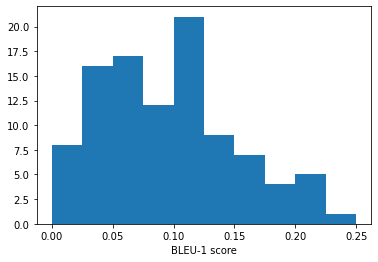

In [35]:
## compute BLEU scores for sample questions
# NOTE these scores are inflated because of the cue words
from data_helpers import compute_text_bleu
from nltk.tokenize import WordPunctTokenizer
bleu_weights = [1.0, 0., 0., 0.]
word_tokenizer = WordPunctTokenizer()
shift_target_text = list(map(lambda x: tokenizer.decode(x['target_ids'], skip_special_tokens=True), mini_shift_val_data))
unshift_pred_text_scores = list(map(
    lambda x: compute_text_bleu(word_tokenizer.tokenize(x[0]), word_tokenizer.tokenize(x[1]), weights=bleu_weights), 
    zip(unshift_pred_text, shift_target_text)))
# plot score distribution
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(unshift_pred_text_scores)
plt.xlabel('BLEU-1 score')
plt.show()

In [24]:
## old code to fix beam search to force decoding with initial words
# def beam_search_with_decoder_input(self,
#         input_ids: torch.LongTensor,
#         beam_scorer: BeamScorer,
#         logits_processor: Optional[LogitsProcessorList] = None,
#         max_length: Optional[int] = None,
#         pad_token_id: Optional[int] = None,
#         eos_token_id: Optional[int] = None,
#         **model_kwargs):
#     """
#     Do beam search using 
#     """
#     ## copied from https://huggingface.co/transformers/_modules/transformers/generation_utils.html#GenerationMixin.beam_search
#     # init values
#     logits_processor = logits_processor if logits_processor is not None else LogitsProcessorList()
#     max_length = max_length if max_length is not None else self.config.max_length
#     pad_token_id = pad_token_id if pad_token_id is not None else self.config.pad_token_id
#     eos_token_id = eos_token_id if eos_token_id is not None else self.config.eos_token_id

#     batch_size = len(beam_scorer._beam_hyps)
#     num_beams = beam_scorer.num_beams

#     batch_beam_size, cur_len = input_ids.shape

#     assert (
#         num_beams * batch_size == batch_beam_size
#     ), "Batch dimension of `input_ids` should be {num_beams * batch_size}, but is {batch_beam_size}."

#     beam_scores = torch.zeros((batch_size, num_beams), dtype=torch.float, device=input_ids.device)
#     beam_scores[:, 1:] = -1e9
#     beam_scores = beam_scores.view((batch_size * num_beams,))

#     while cur_len < max_length:
#         model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

#         outputs = self(**model_inputs, return_dict=True)
#         next_token_logits = outputs.logits[:, -1, :]

#         # adjust tokens for Bart, *e.g.*
#         next_token_logits = self.adjust_logits_during_generation(
#             next_token_logits, cur_len=cur_len, max_length=max_length
#         )

#         next_token_scores = F.log_softmax(next_token_logits, dim=-1)  # (batch_size * num_beams, vocab_size)

#         next_token_scores = logits_processor(input_ids, next_token_scores)
#         next_token_scores = next_token_scores + beam_scores[:, None].expand_as(next_token_scores)
#         # reshape for beam search
#         vocab_size = next_token_scores.shape[-1]
#         next_token_scores = next_token_scores.view(batch_size, num_beams * vocab_size)

#         next_token_scores, next_tokens = torch.topk(
#             next_token_scores, 2 * num_beams, dim=1, largest=True, sorted=True
#         )

#         next_indices = next_tokens // vocab_size
#         next_tokens = next_tokens % vocab_size

#         # stateless
#         beam_outputs = beam_scorer.process(
#             input_ids,
#             next_token_scores,
#             next_tokens,
#             next_indices,
#             pad_token_id=pad_token_id,
#             eos_token_id=eos_token_id,
#         )
#         beam_scores = beam_outputs["next_beam_scores"]
#         beam_next_tokens = beam_outputs["next_beam_tokens"]
#         beam_idx = beam_outputs["next_beam_indices"]

#         input_ids = torch.cat([input_ids[beam_idx, :], beam_next_tokens.unsqueeze(-1)], dim=-1)
#         cur_len = cur_len + 1

#         model_kwargs = self._update_model_kwargs_for_generation(
#             outputs, model_kwargs, is_encoder_decoder=self.config.is_encoder_decoder
#         )
#         if model_kwargs["past"] is not None:
#             model_kwargs["past"] = self._reorder_cache(model_kwargs["past"], beam_idx)

#         if beam_scorer.is_done:
#             break

#     decoded = beam_scorer.finalize(
#         input_ids, beam_scores, next_tokens, next_indices, pad_token_id=pad_token_id, eos_token_id=eos_token_id
#     )

#     return decoded

# def generate_with_decoder_input():
#     """
#     Generate text with decoder input provided (assume beam search for simplicity).
#     Stolen from https://huggingface.co/transformers/_modules/transformers/generation_utils.html#GenerationMixin.generate
#     """
#     # set init values
#     num_beams = num_beams if num_beams is not None else self.config.num_beams
#     max_length = max_length if max_length is not None else self.config.max_length
#     do_sample = do_sample if do_sample is not None else self.config.do_sample
#     num_return_sequences = (
#         num_return_sequences if num_return_sequences is not None else self.config.num_return_sequences
#     )

#     pad_token_id = pad_token_id if pad_token_id is not None else self.config.pad_token_id
#     bos_token_id = bos_token_id if bos_token_id is not None else self.config.bos_token_id
#     eos_token_id = eos_token_id if eos_token_id is not None else self.config.eos_token_id

#     if input_ids is None:
#         # init `input_ids` with bos_token_id
#         input_ids = self._prepare_input_ids_for_generation(bos_token_id)

#     if model_kwargs.get("attention_mask", None) is None:
#         # init `attention_mask` depending on `pad_token_id`
#         model_kwargs["attention_mask"] = self._prepare_attention_mask_for_generation(
#             input_ids, pad_token_id, eos_token_id
#         )

#     # special case if pad_token_id is not defined
#     if pad_token_id is None and eos_token_id is not None:
#         logger.warning(f"Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation.")
#         pad_token_id = eos_token_id

#     if self.config.is_encoder_decoder:
#         # add encoder_outputs to model_kwargs
#         model_kwargs = self._prepare_encoder_decoder_kwargs_for_generation(input_ids, model_kwargs)

#         # set input_ids as decoder_input_ids
#         input_ids = self._prepare_decoder_input_ids_for_generation(
#             input_ids, decoder_start_token_id=decoder_start_token_id, bos_token_id=bos_token_id, **model_kwargs
#         )

#         if "encoder_outputs" not in model_kwargs or not isinstance(model_kwargs["encoder_outputs"], ModelOutput):
#             raise ValueError("Make sure that `model_kwargs` include `encoder_outputs` of type `ModelOutput`.")

#     # determine generation mode
#     is_greedy_gen_mode = (num_beams == 1) and do_sample is False
#     is_sample_gen_mode = (num_beams == 1) and do_sample is True
#     is_beam_gen_mode = (num_beams > 1) and do_sample is False
#     is_beam_sample_gen_mode = (num_beams > 1) and do_sample is True

#     # set model_kwargs
#     model_kwargs["use_cache"] = use_cache

#     # get distribution pre_processing samplers
#     logits_processor = self._get_logits_processor(
#         repetition_penalty=repetition_penalty,
#         no_repeat_ngram_size=no_repeat_ngram_size,
#         bad_words_ids=bad_words_ids,
#         min_length=min_length,
#         eos_token_id=eos_token_id,
#         prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
#         num_beams=num_beams,
#     )
#     batch_size = input_ids.shape[0]

#     length_penalty = length_penalty if length_penalty is not None else self.config.length_penalty
#     early_stopping = early_stopping if early_stopping is not None else self.config.early_stopping

#     if num_return_sequences > num_beams:
#         raise ValueError("`num_return_sequences` has to be smaller or equal to `num_beams`.")

#     beam_scorer = BeamSearchScorer(
#         batch_size=batch_size,
#         max_length=max_length,
#         num_beams=num_beams,
#         device=self.device,
#         length_penalty=length_penalty,
#         do_early_stopping=early_stopping,
#         num_beam_hyps_to_keep=num_return_sequences,
#     )
#     # interleave with `num_beams`
#     input_ids, model_kwargs = self._expand_inputs_for_generation(
#         input_ids, expand_size=num_beams, is_encoder_decoder=self.config.is_encoder_decoder, **model_kwargs
#     )
#     return self.beam_search(
#         input_ids,
#         beam_scorer,
#         logits_processor=logits_processor,
#         max_length=max_length,
#         pad_token_id=pad_token_id,
#         eos_token_id=eos_token_id,
#         **model_kwargs,
#     )
#     pass

# def generate_predictions_with_decoder_input(model, data, tokenizer, cue_ids, device_name='cpu'):
#     num_beams = 4
#     max_decoding_length = 64
#     length_penalty = 1
#     device = torch.device(device_name)
#     model.to(device)
#     pred_text = []
#     for batch_i in tqdm(data):
#         source_i = batch_i['source_ids']
#         attention_i = batch_i['attention_mask']
#         target_i = batch_i['target_ids']
#         # fix type in case of difference
#         if(type(source_i) is list):
#             source_i = torch.LongTensor(source_i)
#         if(type(attention_i) is list):
#             attention_i = torch.Tensor(attention_i)
#         if(type(target_i) is list):
            
#             pass
#         output_i = generate_with_cue(
#             model,
#             input_ids=source_i.to(device).reshape(1,-1),
#             attention_mask=attention_i.to(device).reshape(1,-1),
#             num_beams=num_beams,
#             max_length=max_decoding_length,
#             length_penalty=length_penalty,
#             cue_output_ids=[],
#         )
#         prediction = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_i]
#         pred_text.extend(prediction)
#     return pred_text

### Test decoding parameters
Let's try different decoding parameters to optimize the quality of generated questions. 

We want to optimize:

- similarity to target question(s)
- relevance to article content
- non-obvious answers (e.g. not "Who is Barack Obama?")

We'll experiment with the following parameters:

- beam count (higher => more diverse answers)
- temperature (higher => more random)
- top-p filtering (higher => more random/noisy because more words to choose from: https://huggingface.co/blog/how-to-generate)

In [2]:
## load model
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
cache_dir = '../../data/nyt_comments/model_cache/'
generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
trained_model_state_dict_file = '../../data/nyt_comments/question_generation_model/checkpoint-96000/pytorch_model.bin' # checkpoint model
trained_model_state_dict = torch.load(trained_model_state_dict_file)
generation_model.load_state_dict(trained_model_state_dict)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
## load evaluation data
val_data_file = '../../data/nyt_comments/NYT_question_data_val_data.pt'
val_data = torch.load(val_data_file)['train']
mini_val_data = val_data.select(list(range(500)))

In [3]:
## convert source text to sentences, tokens
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
sent_tokenizer = PunktSentenceTokenizer()
word_tokenizer = WordPunctTokenizer()
article_sent_tokens = list(map(lambda x: list(map(lambda y: word_tokenizer.tokenize(y), sent_tokenizer.tokenize(x))), mini_val_data['source_text']))
## convert target text to tokens
target_question_tokens = list(map(lambda x: word_tokenizer.tokenize(x), mini_val_data['target_text']))

In [4]:
## test the metrics on basic generation model
from data_helpers import generate_predictions
import torch
device_name = 'cuda:0'
pred_text = generate_predictions(generation_model, mini_val_data, tokenizer, device_name=device_name)
torch.cuda.empty_cache()

100%|██████████| 500/500 [01:16<00:00,  6.54it/s]


In [5]:
from data_helpers import compute_text_bleu
def compute_question_scores(article_sent_tokens, target_question_tokens, pred_question_tokens, weights):
    ## metric: similarity to article
    # get maximum overlap with sentence
    max_article_sent_score = 0.
    max_article_sent = []
    for article_sent_tokens_i in article_sent_tokens:
        sent_score_i = compute_text_bleu(article_sent_tokens_i, pred_question_tokens, weights)
        if(sent_score_i > max_article_sent_score):
            max_article_sent_score = sent_score_i
            max_article_sent = ' '.join(list(article_sent_tokens_i))
    ## metric: similarity to target question
    target_question_score = compute_text_bleu(target_question_tokens, pred_question_tokens, weights)
    ## TODO metric: diversity? as compared to other questions
    return max_article_sent_score, max_article_sent, target_question_score

In [6]:
## compute metrics
import pandas as pd
pred_text_tokens = list(map(word_tokenizer.tokenize, pred_text))
pred_text_data = pd.DataFrame([
    article_sent_tokens,
    target_question_tokens,
    pred_text
], index=['source', 'target', 'pred']).transpose()
from pandarallel import pandarallel
num_workers = 4
pandarallel.initialize(nb_workers=num_workers, progress_bar=True)
bleu_weights = [1.0, 0., 0., 0.]
pred_text_scores = pred_text_data.parallel_apply(lambda x: compute_question_scores(x.loc['source'], x.loc['target'], x.loc['pred'], bleu_weights), axis=1)
# organize
pred_text_scores = pd.DataFrame(pred_text_scores.values.tolist(), columns=['max_article_sent_score', 'max_article_sent', 'target_question_score'])
# add pred text, target text
pred_text_scores = pred_text_scores.assign(**{
    'pred_text' : pred_text_data.loc[:, 'pred'].values,
    'target_text' : pred_text_data.loc[:, 'target'].apply(lambda x: ' '.join(x)),
    'article_id' : mini_val_data['article_id']
})

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

In [7]:
# show top-scoring questions for article similarity
pd.set_option('display.max_colwidth', 200)
pred_text_scores.sort_values('max_article_sent_score', inplace=True, ascending=False)
print('top matches with article')
display(pred_text_scores.drop_duplicates('article_id').head(10))
# show top-scoring questions for target similarity
pred_text_scores.sort_values('target_question_score', inplace=True, ascending=False)
print('top matches with target')
display(pred_text_scores.drop_duplicates('article_id').head(10))

top matches with article


,max_article_sent_score,max_article_sent,target_question_score,pred_text,target_text,article_id
327,0.150000,"But the bond company , citing the fact that she had a Texas driver ' s license , required her to wear an ankle monitor -- at a cost of $ 300 a month .",0.025000,"Is someone making $ 25, 000 a year rich?",Is it in every case ?,5abf4e1b068401528a2a0138
499,0.144855,Hicks ' s proximity to the president has also been a matter of interest to those investigating the Trump campaign ' s ties to Russian officials .,0.045455,What did Ms. Hicks do?,Is this why Trump sounded like he was throwing in the towel in Ohio ?,5abd88f8068401528a29f6c1
493,0.134615,"I kept telling Congress , if funding continues to be constrained , it ' s not a matter of if , it ' s a matter of when the system fails ,"" said Mr .",0.019231,"If the President doesn't have to pay, why should we?",And this president supposedly is a good businessman ???,5ad630d2068401528a2a92c3
186,0.131579,"“ It ’ s hard to go after a wheat grower , because who is a wheat grower ?",0.026316,"Win win for liberals, what's the fuss?",Maybe aficionados will buy more French wines -- but Australian or Chilean ?,5ac342a1068401528a2a14f4
172,0.130435,"There ’ s something bizarre about being a veteran of a war that doesn ’ t end , in a country that doesn ’ t pay attention .",0.021739,"Have you read Shirley Jackson's"" The Lottery""?",If they find comfort from their loneliness and boredom punctuated by wild firefights or indirect fires in ( what now could literally be ) Timbuktu with some cynical snark about homefront apathy ( ...,5ad248b3068401528a2a8b84
492,0.122449,"I think I ' m increasingly viewed now as not just a Republican but as something different , kind of a hybrid ,"" he said in a half - hour interview on Tuesday , shuttling between stops in an S . U .",0.020408,"So are most people their age, havent you noticed?",As for his abortion acquiescence to conservatives in Ohio : how many women actually get abortions for non - life threatening reasons after week 20 ?,5ac50f0b068401528a2a25e6
440,0.121212,"I Feel Pretty "" is practically a feature - length version of that Dove ad in which a forensic sketch artist illustrates women ' s distorted ideas of their own looks .",0.060606,Is that something to be emulated?,"Now that we are stuck in the world of visual media where everyone is their own master , how do we use this power to create a deeper shift ?",5adde6e8068401528a2aa2cb
80,0.119048,"I ' ve had about a hundred of them over the past few years , and I doubt there ' s a single one I could pick out of a police lineup .",0.047619,Who hasn't closed a meal with that lately?,"This is a joke , right ?",5accd3ce068401528a2a63cd
240,0.117647,"If you have a swimming pool or a bathtub , that ’ s more dangerous to neighborhood kids than a gun is .",0.058824,How to win an argument about guns?,"Or is there such a thing as reasonable gun restrictions , and , if so , can we rationally figure out what that might be ?",5ac4093f068401528a2a1ca9
170,0.115385,"Trump ' s entire presidency , particularly with the appointment of a special counsel to investigate Russia ' s election interference .",0.076923,Is this some sort of game?,Didn ' t last time Syrian government already surrender all the chem bombs and U . S . satisfied after counted and destroyed them ?,5acdf126068401528a2a7067


top matches with target


,max_article_sent_score,max_article_sent,target_question_score,pred_text,target_text,article_id
139,0.111111,The first scene began with Harrison ' s revealing himself from behind a pillar .,0.111111,A news peg at all?,"But , is there a reason for it ?",5ad11cf0068401528a2a89c2
193,0.075957,They are basically running a full - on propaganda campaign but withholding the information that the American people need to be able to make an informed decision about this nominee ' s fitness for ...,0.100000,"Why is she not under indictment, anyway?","Is the misspelling of Gina Haspel ' s first name , as Gian in the first tweet , reported as is , or is it a typo by whomever typed the article ?",5ada0827068401528a2a9d29
252,0.096774,"Trump ' s push for a border wall , ending the so - called catch - and - release practice and lauding the administration ' s efforts on securing borders .",0.096774,Who's in charge in the WH??????,Doesn ' t he appearances on FOX amount to an in person leak ?,5ac2ad5a068401528a2a1043
95,0.088971,"“ If you ’ re creating a policy , it can ’ t be done in a vacuum ,” he said .",0.094054,Who am I to judge?,What can a cheerleader do that can reflect badly on the team when the players are such low lives themselves ?,5acdeba1068401528a2a7042
88,0.080908,"The miraculous thing is that he didn ’ t . In the battlefield of ideas and ideology that is health economics , Uwe was always a calm voice of reason , telling people things they didn ’ t want to h...",0.093023,Bing-how does that undermine what Soc says?,"Here ' s a sample of Uwe Reinhardt ' s class and humor , from his 2017 column "" Where Does the Health Insurance Premium Dollar Go ?",5adcaffc068401528a2aa0ad
57,0.098044,"Early on , Agnew positioned himself as a racial liberal -- he won the governor ' s office in 1966 by running to the left on civil rights against George P . Mahoney , a pro - segregation Democrat .",0.092279,Anti-bussing and pro segregation?,Does the rise of Trump and a more emboldened white supremacist movement signal the beginning of the decline of power and influence for the GOP ' s white - driven divisive racial politics or does t...,5abfd3ae068401528a2a034e
418,0.114484,"Since a three - judge panel can ’ t overturn a circuit court ’ s precedent , an 11 - judge panel heard this case .",0.086957,Why am I not surprised?,"If Judge Reinhardt really wanted to preserve a long - lasting progressive legacy , why would he assume that he was immortal ?",5acf2aa4068401528a2a7e16
237,0.065217,"The search warrant carried out by the public corruption unit of the United States attorney ' s office in Manhattan sought information about Karen McDougal , a former Playboy model who claims she c...",0.086957,Is it a crime if you pay blackmail to someone?,Isn ’ t it so cute that all the Trump supporters here seem to think this is a ALL about sex with a porn star ?,5accdbbf068401528a2a642a
82,0.054054,"Enrollment on the Affordable Care Act ’ s insurance exchanges has also declined since 2016 — with almost all the decline taking place in Trump administration - run exchanges , rather than those ru...",0.081081,"But, honestly, can't they keep their ill-informed decisions to themselves?","Trouble is , with Trump ' s ability to fabricate nonsense , and an anti - environment E . P . A . with Pruitt , and warmonger Bolton in the wings , who knows what the next distraction will be ?",5acbffd0068401528a2a5cbe
264,0.078431,"But this national average is a bit deceptive : Teacher pay is actually up in some big states like New York and California , but it ’ s way down in a number of right - leaning states .",0.078431,Why is anti-union legislation called Right to Work?,Why invest in the nation ' s children and its future when you can invest in a small number of right - wing millionaires and billionaires instead ?,5ade6193068401528a2aa41e


The top-scoring predicted questions are still not really good matches, generally because of complex sentences in the articles and in the target questions.

In [8]:
## run generation ONLY ON SAMPLE! otherwise this will take days
# pred_data_sample_size = 100
# sample_val_data = val_data.select(list(range(pred_data_sample_size)))
generation_parameter_settings = {
    'beam_count' : [2, 5, 10],
    'temperature' : [0.1, 0.5, 1.],
    'top_p' : [0.05, 0.25, 0.5],
}
from itertools import product
beam_generation_parameter_combos = list(product(
    generation_parameter_settings['beam_count'], 
    generation_parameter_settings['temperature'], 
))
sample_generation_parameter_combos = list(product(
    generation_parameter_settings['temperature'], 
    generation_parameter_settings['top_p'], 
))

In [9]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import generate_predictions
def get_parameter_test_scores(data, tokenizer, device_name, 
                              generation_method, parameters,
                              bleu_weights=[1.0, 0., 0., 0.]):
    target_questions = data['target_text']
    if(generation_method=='beam_search'):
        beam_count, temperature = parameters
        pred_text = generate_predictions(generation_model, data, tokenizer, device_name=device_name, 
                                         generation_method=generation_method,
                                         num_beams=beam_count, 
                                         temperature=temperature)
    elif(generation_method=='sample'):
        temperature, top_p = parameters
        pred_text = generate_predictions(generation_model, data, tokenizer, device_name=device_name, 
                                         generation_method=generation_method,
                                         temperature=temperature,
                                         top_p=top_p)
    # organize data
    pred_text_tokens = list(map(word_tokenizer.tokenize, pred_text))
    pred_text_data = pd.DataFrame([
        article_sent_tokens,
        target_question_tokens,
        pred_text_tokens,
    ], index=['source', 'target', 'pred']).transpose()
    # compute match scores
    pred_text_scores = pred_text_data.parallel_apply(lambda x: compute_question_scores(x.loc['source'], x.loc['target'], x.loc['pred'], bleu_weights), axis=1)
    # organize
    pred_text_scores = pd.DataFrame(pred_text_scores.values.tolist(), columns=['max_article_sent_score', 'max_article_sent', 'target_question_score'])
    # raw text for comparison
    pred_text_scores = pred_text_scores.assign(**{
        'pred_text' : pred_text,
        'target_text' : target_questions,
    })
    # parameters
    if(generation_method == 'beam_search'):
        pred_text_scores = pred_text_scores.assign(**{
            'beam_count' : beam_count,
            'temperature' : temperature,
        })
    elif(generation_method == 'sample'):
        pred_text_scores = pred_text_scores.assign(**{
            'temperature' : temperature,
            'top_p' : top_p,
        })
    return pred_text_scores

In [10]:
## beam search
generation_method = 'beam_search'
beam_parameter_test_scores = []
device_name = 'cuda:0'
bleu_weights = [1.0, 0., 0., 0.]
for combo_i in beam_generation_parameter_combos:
    pred_text_scores_i = get_parameter_test_scores(mini_val_data, tokenizer, device_name, 
                                                   generation_method, combo_i,
                                                   bleu_weights=bleu_weights)
    beam_parameter_test_scores.append(pred_text_scores_i)
beam_parameter_test_scores = pd.concat(beam_parameter_test_scores, axis=0)

100%|██████████| 500/500 [01:06<00:00,  7.54it/s]
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

In [11]:
## top-P sampling
generation_method = 'sample'
sample_parameter_test_scores = []
device_name = 'cuda:0'
bleu_weights = [1.0, 0., 0., 0.]
for combo_i in sample_generation_parameter_combos:
    pred_text_scores_i = get_parameter_test_scores(mini_val_data, tokenizer, device_name, 
                                                   generation_method, combo_i,
                                                   bleu_weights=bleu_weights)
    sample_parameter_test_scores.append(pred_text_scores_i)
sample_parameter_test_scores = pd.concat(sample_parameter_test_scores, axis=0)

100%|██████████| 500/500 [01:15<00:00,  6.60it/s]


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

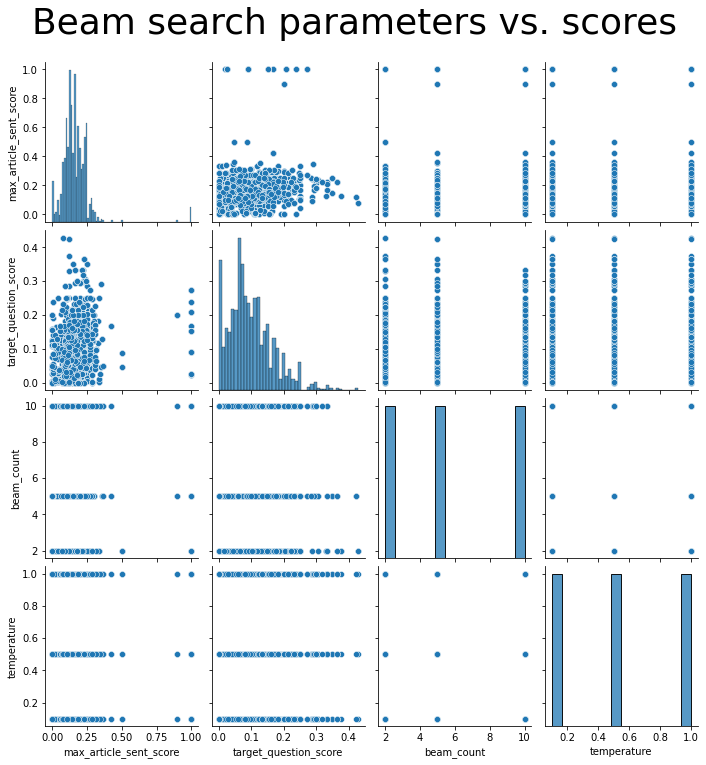

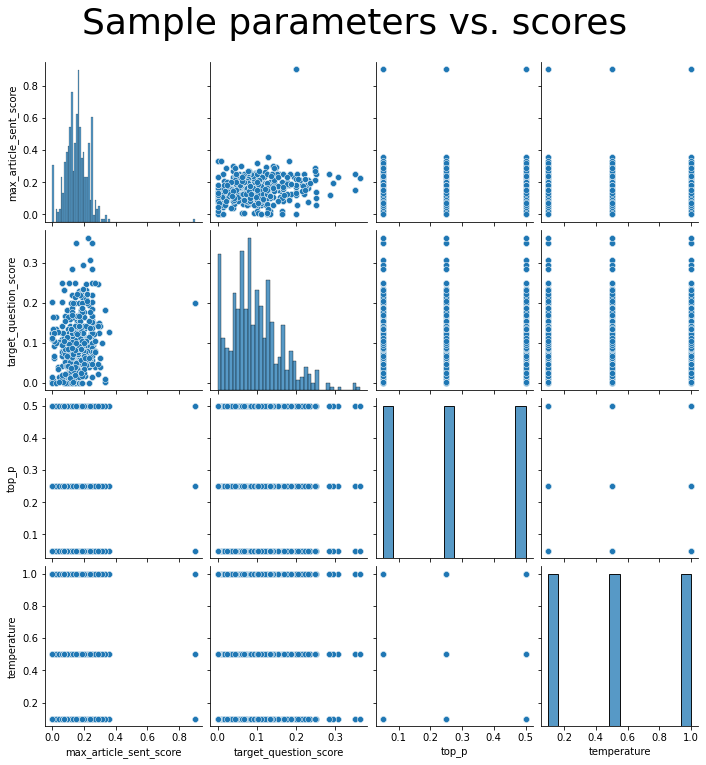

In [16]:
## do some models consistently do better with overlap scores?
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
score_vars = ['max_article_sent_score', 'target_question_score',]
param_vars = ['beam_count', 'temperature']
plot_vars = score_vars + param_vars
## beam search
sns.pairplot(data=beam_parameter_test_scores.loc[:, plot_vars])
plt.suptitle('Beam search parameters vs. scores', fontsize=36, y=1.06)
plt.show()
## sample
param_vars = ['top_p', 'temperature']
plot_vars = score_vars + param_vars
sns.pairplot(data=sample_parameter_test_scores.loc[:, plot_vars])
plt.suptitle('Sample parameters vs. scores', fontsize=36, y=1.06)
plt.show()

Quantitative results: did the sampling approach produce questions with higher scores than beam search?

In [13]:
from scipy.stats import mannwhitneyu
score_vars = ['max_article_sent_score', 'target_question_score',]
for score_var in score_vars:
    beam_scores = beam_parameter_test_scores.loc[:, score_var]
    sample_scores = sample_parameter_test_scores.loc[:, score_var]
    # remove exact matches
    beam_scores = beam_scores[beam_scores != 1.0]
    sample_scores = sample_scores[sample_scores != 1.0]
    score_diff = beam_scores.median() - sample_scores.median()
    test_stat, p_val = mannwhitneyu(beam_scores, sample_scores)
    print(f'score var {score_var} has difference %.3E, test stat = %.3f (p=%.3E)'%(score_diff, test_stat, p_val))

OK! Sample-based decoding does a little better at matching sentences from the article, even after we remove exact matches (same result when including exact matches).

In [17]:
# show top-scoring matches
## beam search
print('beam search tests')
print('top-scoring questions by target score')
display(beam_parameter_test_scores.sort_values('target_question_score', inplace=False, ascending=False).drop_duplicates('target_text').head(20))
print('top-scoring questions by article score')
# get rid of exact matches, some data overlap between source/target
display(beam_parameter_test_scores[beam_parameter_test_scores.loc[:, 'max_article_sent_score']!=1.0].sort_values('max_article_sent_score', inplace=False, ascending=False).drop_duplicates('target_text').head(20))

beam search tests
top-scoring questions by target score


,max_article_sent_score,max_article_sent,target_question_score,pred_text,target_text,beam_count,temperature
128,0.080674,"Comey “ is not smart !” Hours later , Mr .",0.428571,What is your policy in Syria?,What is it going to take?,2,0.1
318,0.119422,The rule of law is not safe .,0.423241,And what of Trumps enablers?,"50 % of what, exactly?",5,0.5
205,0.125000,Trump has not managed to build one .,0.375000,Why dont you just move to China?,Are we just going to ask nice?,2,1.0
472,0.227387,Comey only appeared to play into the hands of allies of Mr .,0.363636,Why is it bad for Comey to speak the truth?,Speaking truth to the biggest con man in American history?,2,0.1
302,0.150000,"Knowing what you know now , do you feel any differently about vaping ?",0.350000,"People seem to get the notion that vaping is much healthier than cigarettes, so whats the big deal?","People who vape in school are stupid, how is that going to get you anywhere in life?",5,1.0
84,0.250000,"Russia ' s response was not unanticipated , and the United States will deal with it .""",0.350000,Is this the beginning of a new cold war between Trump's America and Putin's Russia?,I wonder if this was all part of Putin's plan when he helped Trump get elected?,5,0.1
390,0.166667,What is your role ?,0.333333,They serve meals on airplanes?,They ask customers for ideas?,2,1.0
483,0.166667,"Condemnation of the strikes from Syria ' s allies was swift .""",0.333333,Is there any independent verification of what the bombs actually struck?,(Is the light of Syria real?,5,0.1
2,0.211620,"So why this crusade against guns , but not against bathtubs and pools ?",0.333333,"Why not compare to Pittsburgh, Miami or heaven forbid Baltimore?",Why not bring up the comparison to cigarettes?,10,1.0
241,0.222222,"Trump said , according to Mr .",0.333333,"Who is more credible, Trump or Comey?","Seriously, that is what you are saying?",2,0.5


top-scoring questions by article score


,max_article_sent_score,max_article_sent,target_question_score,pred_text,target_text,beam_count,temperature
217,0.900000,Will there be anything like that with Trump ?,0.200000,""" Will there be anything like that with Trump?",Or the Republican party for that matter?,5,0.1
404,0.500000,Why would this time be different ?,0.045985,Why can't this be changed?,How many of us grew up with planning on how to escape shooters in school?,2,0.1
309,0.500000,Why would this time be different ?,0.085911,Why can't this be changed?,When are those members going to do something about that?,2,0.5
1,0.423241,The state ' s contract with Management & Training Corporation is particularly economical .,0.166667,"What is Management & amp ; Training Corporation"" s profit?","What kind of people live in, govern, Mississippi?",10,0.5
379,0.363636,Where was the home inspector in all this ?,0.048110,Who changes the light bulbs in all that wasted space?,"I"" ll still watch because it is mindless TV, but could we have unique designs?",10,0.1
252,0.355883,"Trump ' s State of the Union address in January .""",0.127501,Who's in charge in the WH??????,Doesn't he appearances on FOX amount to an in person leak?,5,0.1
346,0.350069,"The officer appeared to shoot him in the neck , chest and right arm , Mr .",0.291724,Couldn't 1 officer shoot him in the leg and take him down?,"Before approaching, wouldn't u command him to freeze and immediately show your hands?",10,0.1
0,0.350069,"The officer appeared to shoot him in the neck , chest and right arm , Mr .",0.044688,Couldn't 1 officer shoot him in the leg and take him down?,These officers will say they feared for their lives but should we have police officers who are so easily frightened?,10,1.0
440,0.343645,And who wants to criticize a woman ' s choice ?,0.023973,Someone wants to be a pro cheerleader?,"Now that we are stuck in the world of visual media where everyone is their own master, how do we use this power to create a deeper shift?",10,0.5
426,0.333333,"Juszkiewicz , in an interview , didn ' t sugarcoat it .""",0.250000,"Gee, ain't it funny how time slips away?",One wonders how much of the market this is taking away?,10,0.1


In [18]:
## sample
print('sample tests')
print('top-scoring questions by target score')
display(sample_parameter_test_scores.sort_values('target_question_score', inplace=False, ascending=False).drop_duplicates('target_text').head(20))
print('top-scoring questions by article score')
display(sample_parameter_test_scores[sample_parameter_test_scores.loc[:, 'max_article_sent_score']!=1.0].sort_values('max_article_sent_score', inplace=False, ascending=False).drop_duplicates('target_text').head(20))

sample tests
top-scoring questions by target score


,max_article_sent_score,max_article_sent,target_question_score,pred_text,target_text,temperature,top_p
472,0.227387,Comey only appeared to play into the hands of allies of Mr .,0.363636,Why is it bad for Comey to speak the truth?,Speaking truth to the biggest con man in American history?,0.5,0.50
302,0.150000,"Knowing what you know now , do you feel any differently about vaping ?",0.350000,"People seem to get the notion that vaping is much healthier than cigarettes, so whats the big deal?","People who vape in school are stupid, how is that going to get you anywhere in life?",1.0,0.50
84,0.250000,"Russia ' s response was not unanticipated , and the United States will deal with it .""",0.350000,Is this the beginning of a new cold war between Trump's America and Putin's Russia?,I wonder if this was all part of Putin's plan when he helped Trump get elected?,0.5,0.50
199,0.235294,Hannity seemed to suggest that he had not disclosed his link to Mr .,0.306842,Why would Hannity expect his conversations to be Confidentialif if Cohen is not paid or retained?,Can someone explain to me why it is bad or embarrassing for Sean Hannity to be a client of Mr Cohen?,0.5,0.50
303,0.197229,"During the struggle , Officer Pantaleo said he feared he would be pushed through a storefront window behind him .",0.294118,Did he think his physical strength would allow him to overcome that of a police unit?,Did he think he was going to escape?,1.0,0.25
132,0.123840,"For markets , nothing is for sure .",0.285714,Who is going to stop them?,This is trumps way of winning?,0.1,0.05
321,0.250000,"Russia ' s response was not unanticipated , and the United States will deal with it .""",0.285369,Is this the beginning of a new cold war between Trump's America and Putin's Russia?,Without a presence in St. Petersburg how will we keep eyes on the Putin government's internet provocateurs?,1.0,0.50
431,0.141080,The MoCA examination was simply not sufficient under the circumstances to support Dr .,0.250000,How on earth is he competent to run the VA system?,Did he know to score only spontaneous recall?,1.0,0.50
143,0.104216,They are some of the first known affected Facebook users to be publicly identified .,0.250000,Will Facebook tell them the whole truth?,How seriously do I take Facebook ads?,0.5,0.05
194,0.059046,"It is not clear they could have done anything differently ,"" he said .",0.250000,What is wrong with American law enforcement?,"Oh, where is justice?",0.1,0.05


top-scoring questions by article score


,max_article_sent_score,max_article_sent,target_question_score,pred_text,target_text,temperature,top_p
217,0.900000,Will there be anything like that with Trump ?,0.200000,""" Will there be anything like that with Trump?",Or the Republican party for that matter?,0.5,0.50
252,0.355883,"Trump ' s State of the Union address in January .""",0.127501,Who's in charge in the WH??????,Doesn't he appearances on FOX amount to an in person leak?,0.1,0.25
418,0.333333,Why bother ?,0.009803,Why am I not surprised?,"If Judge Reinhardt really wanted to preserve a long-lasting progressive legacy, why would he assume that he was immortal?",1.0,0.05
244,0.333333,Why bother ?,0.000424,Why am I not surprised?,"But you find no fault with a court that not only invents a right to privacy but extends that invented right to cover abortion and then invents a trimester system for enforcing it, none of which ex...",0.5,0.50
80,0.332037,I can ' t imagine a better dessert for that restaurant .,0.181818,Who hasn't closed a meal with that lately?,"This is a joke, right?",0.5,0.50
447,0.316693,"Wiley said , in response to the president ' s argument that immigrants are taking work from native - born Americans .""",0.100000,When are Americans in general and especially Trump supporters finally going to understand that immigrants are NOT the enemy?,But who cares about people when profit is all that really matters right?,1.0,0.50
248,0.298555,Trump ' s casino helped launder money and no one was charged with a crime .,0.039970,Why was Trump and Manafort not charged with crimes BEFORE now?,"If you believe in justice for all, wouldn't a purge of these corrupt and venal politicians such as Pruitt and Trump be one of the best things for the country?",1.0,0.50
214,0.298555,Trump ' s casino helped launder money and no one was charged with a crime .,0.060630,Why was Trump and Manafort not charged with crimes BEFORE now?,Remember when Credit Suisse in 2006 was fined $ 536 million for laundering money for Iranian banks that were funding Iran ’ s nuclear bomb and missile programs?,0.1,0.05
399,0.298555,Trump ' s casino helped launder money and no one was charged with a crime .,0.141080,Why was Trump and Manafort not charged with crimes BEFORE now?,Must he be tasked with saving the rule of law in America too?,0.1,0.05
262,0.296327,"On the other hand , it illuminates the truth of his experience .",0.148976,"Also, what about the rest of the letter?",How would not sharing the letter be any different than if it had never been found?,0.5,0.25


For beam search, we find that:

- fewer beams => better for target question overlap
- more beams => slightly better for article sentence overlap

For sampling, we find that:

- no clear connection between top-P and target/article overlap
- slightly better than beam search overall for article sentence overlap

### Old code

Testing how to add custom tokens to vocab.

In [55]:
from transformers import BartTokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
## add special tokens
# author location
tokenizer.add_special_tokens({'cls_token' : '<US_AUTHOR>'})
tokenizer.add_special_tokens({'cls_token' : '<NONUS_AUTHOR>'})
# author comment count info
tokenizer.add_special_tokens({'cls_token' : '<COMMENT_COUNT_0_AUTHOR>'})
tokenizer.add_special_tokens({'cls_token' : '<COMMENT_COUNT_1_AUTHOR>'})
# author comment len info
tokenizer.add_special_tokens({'cls_token' : '<COMMENT_LEN_0_AUTHOR>'})
tokenizer.add_special_tokens({'cls_token' : '<COMMENT_LEN_1_AUTHOR>'})

1

In [56]:
import re
test_sents = [
    '<US_AUTHOR> tokenize this sentence please',
    '<NONUS_AUTHOR> tokenize this sentence please'
]
for test_sent in test_sents:
    test_tokens = tokenizer.tokenize(test_sent)
    # cleanup fml
    # word_cleaner = re.compile('Ġ')
    # test_tokens = list(map(lambda x: word_cleaner.sub('', x), test_tokens))
    print(test_tokens)

['<US_AUTHOR>', 'token', 'ize', 'Ġthis', 'Ġsentence', 'Ġplease']
['<NONUS_AUTHOR>', 'token', 'ize', 'Ġthis', 'Ġsentence', 'Ġplease']


In [67]:
tokenizer.convert_tokens_to_string(['<US_AUTHOR>', 'token', 'ize', 'Ġthis', 'Ġsentence', 'Ġplease'])

'<US_AUTHOR>tokenize this sentence please'